In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm


from torchaudio.datasets import SPEECHCOMMANDS
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# DataSet creation

In [3]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

## Create training and testing split of the data. We do not use validation in this tutorial.

In [4]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [5]:
def cut_dataset(dataset, labels):
    items_to_remove = []
    for i, (_, _, label, *_) in enumerate(dataset):
        if label not in labels:
            items_to_remove.append(i)

    for elem in sorted(items_to_remove, reverse=True):
        dataset._walker.pop(elem)

In [6]:
commands = ["forward", "backward", "left", "right", "stop", "on", "off"]

In [7]:
cut_dataset(train_set, commands)
cut_dataset(test_set, commands)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


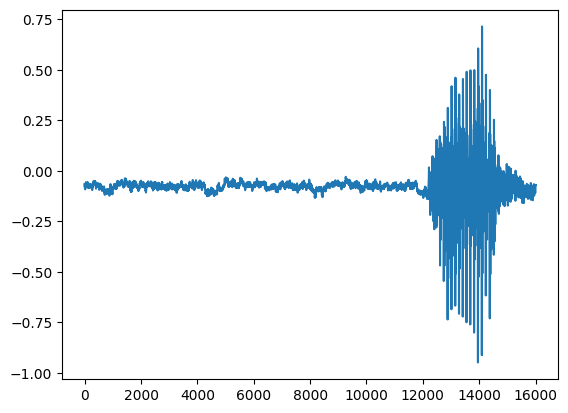

In [8]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy());

In [9]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward', 'forward', 'left', 'off', 'on', 'right', 'stop']

In [10]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [11]:
new_sample_rate = 3500
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform_second)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [12]:
transformed.shape

torch.Size([1, 3500])

In [13]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "forward"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

forward --> tensor(1) --> forward


In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [15]:
next(iter(train_loader))[0].shape

torch.Size([256, 1, 16000])

# Define the Network

In [16]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

class M4(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M4(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M4(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=7, bias=True)
)
Number of parameters: 9223


In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# Training and Testing the Network

In [18]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

  0%|          | 0.11249999999999999/200 [00:00<10:52,  3.27s/it]

Train Epoch: 1 [0/17825 (0%)]	Loss: 2.012500


  0%|          | 0.36250000000000016/200 [00:00<06:21,  1.91s/it]

Train Epoch: 1 [5120/17825 (29%)]	Loss: 1.545873


  0%|          | 0.6249999999999998/200 [00:01<04:46,  1.44s/it] 

Train Epoch: 1 [10240/17825 (57%)]	Loss: 1.311219


  0%|          | 0.7999999999999992/200 [00:01<04:27,  1.34s/it]

Train Epoch: 1 [15360/17825 (86%)]	Loss: 1.028082


  0%|          | 0.9874999999999985/200 [00:01<04:52,  1.47s/it]


Test Epoch: 1	Accuracy: 1288/2337 (55%)



  1%|          | 1.0749999999999982/200 [00:01<05:28,  1.65s/it]

Train Epoch: 2 [0/17825 (0%)]	Loss: 1.056756


  1%|          | 1.3374999999999972/200 [00:02<05:09,  1.56s/it]

Train Epoch: 2 [5120/17825 (29%)]	Loss: 0.790725


  1%|          | 1.5999999999999963/200 [00:02<04:28,  1.35s/it]

Train Epoch: 2 [10240/17825 (57%)]	Loss: 0.890435


  1%|          | 1.8624999999999954/200 [00:02<04:16,  1.29s/it]

Train Epoch: 2 [15360/17825 (86%)]	Loss: 0.755569


  1%|          | 1.949999999999995/200 [00:03<05:04,  1.54s/it] 


Test Epoch: 2	Accuracy: 1680/2337 (72%)



  1%|          | 2.024999999999995/200 [00:03<05:45,  1.75s/it]

Train Epoch: 3 [0/17825 (0%)]	Loss: 0.798755


  1%|          | 2.3374999999999995/200 [00:03<05:36,  1.70s/it]

Train Epoch: 3 [5120/17825 (29%)]	Loss: 0.595045


  1%|▏         | 2.6750000000000043/200 [00:04<04:25,  1.35s/it]

Train Epoch: 3 [10240/17825 (57%)]	Loss: 0.636047


  1%|▏         | 2.8500000000000068/200 [00:04<04:11,  1.27s/it]

Train Epoch: 3 [15360/17825 (86%)]	Loss: 0.775639


  1%|▏         | 2.937500000000008/200 [00:04<05:03,  1.54s/it] 


Test Epoch: 3	Accuracy: 1754/2337 (75%)



  2%|▏         | 3.012500000000009/200 [00:04<05:49,  1.78s/it]

Train Epoch: 4 [0/17825 (0%)]	Loss: 0.591176


  2%|▏         | 3.287500000000013/200 [00:05<04:32,  1.38s/it] 

Train Epoch: 4 [5120/17825 (29%)]	Loss: 0.650838


  2%|▏         | 3.637500000000018/200 [00:05<04:25,  1.35s/it] 

Train Epoch: 4 [10240/17825 (57%)]	Loss: 0.699637


  2%|▏         | 3.8125000000000204/200 [00:05<04:13,  1.29s/it]

Train Epoch: 4 [15360/17825 (86%)]	Loss: 0.625323


  2%|▏         | 4.000000000000023/200 [00:06<04:30,  1.38s/it] 


Test Epoch: 4	Accuracy: 1706/2337 (73%)



  2%|▏         | 4.087500000000024/200 [00:06<05:21,  1.64s/it]

Train Epoch: 5 [0/17825 (0%)]	Loss: 0.570300


  2%|▏         | 4.337500000000028/200 [00:06<05:14,  1.61s/it]

Train Epoch: 5 [5120/17825 (29%)]	Loss: 0.548485


  2%|▏         | 4.600000000000032/200 [00:07<04:21,  1.34s/it]

Train Epoch: 5 [10240/17825 (57%)]	Loss: 0.579964


  2%|▏         | 4.862500000000035/200 [00:07<04:04,  1.25s/it]

Train Epoch: 5 [15360/17825 (86%)]	Loss: 0.563185


  2%|▏         | 4.950000000000037/200 [00:07<04:58,  1.53s/it]


Test Epoch: 5	Accuracy: 1864/2337 (80%)



  3%|▎         | 5.025000000000038/200 [00:07<05:35,  1.72s/it]

Train Epoch: 6 [0/17825 (0%)]	Loss: 0.508946


  3%|▎         | 5.375000000000043/200 [00:08<05:04,  1.56s/it]

Train Epoch: 6 [5120/17825 (29%)]	Loss: 0.491231


  3%|▎         | 5.637500000000046/200 [00:08<04:21,  1.35s/it]

Train Epoch: 6 [10240/17825 (57%)]	Loss: 0.484874


  3%|▎         | 5.812500000000049/200 [00:08<04:10,  1.29s/it]

Train Epoch: 6 [15360/17825 (86%)]	Loss: 0.586932


  3%|▎         | 5.90000000000005/200 [00:08<05:05,  1.57s/it] 


Test Epoch: 6	Accuracy: 1797/2337 (77%)



  3%|▎         | 6.012500000000052/200 [00:09<05:30,  1.70s/it]

Train Epoch: 7 [0/17825 (0%)]	Loss: 0.530606


  3%|▎         | 6.375000000000057/200 [00:09<04:58,  1.54s/it]

Train Epoch: 7 [5120/17825 (29%)]	Loss: 0.508043


  3%|▎         | 6.637500000000061/200 [00:09<04:17,  1.33s/it]

Train Epoch: 7 [10240/17825 (57%)]	Loss: 0.532528


  3%|▎         | 6.812500000000063/200 [00:10<04:06,  1.27s/it]

Train Epoch: 7 [15360/17825 (86%)]	Loss: 0.583578


  3%|▎         | 6.9875000000000655/200 [00:10<04:37,  1.44s/it]


Test Epoch: 7	Accuracy: 1907/2337 (82%)



  4%|▎         | 7.062500000000067/200 [00:10<05:17,  1.65s/it] 

Train Epoch: 8 [0/17825 (0%)]	Loss: 0.439109


  4%|▎         | 7.32500000000007/200 [00:10<05:08,  1.60s/it] 

Train Epoch: 8 [5120/17825 (29%)]	Loss: 0.397738


  4%|▍         | 7.675000000000075/200 [00:11<04:07,  1.29s/it]

Train Epoch: 8 [10240/17825 (57%)]	Loss: 0.594474


  4%|▍         | 7.850000000000078/200 [00:11<03:57,  1.24s/it]

Train Epoch: 8 [15360/17825 (86%)]	Loss: 0.371654


  4%|▍         | 7.937500000000079/200 [00:11<04:46,  1.49s/it]


Test Epoch: 8	Accuracy: 1898/2337 (81%)



  4%|▍         | 8.01250000000008/200 [00:11<05:33,  1.74s/it] 

Train Epoch: 9 [0/17825 (0%)]	Loss: 0.434333


  4%|▍         | 8.375000000000059/200 [00:12<04:50,  1.52s/it]

Train Epoch: 9 [5120/17825 (29%)]	Loss: 0.438975


  4%|▍         | 8.637500000000044/200 [00:12<04:09,  1.30s/it]

Train Epoch: 9 [10240/17825 (57%)]	Loss: 0.497182


  4%|▍         | 8.812500000000034/200 [00:12<03:57,  1.24s/it]

Train Epoch: 9 [15360/17825 (86%)]	Loss: 0.410527


  4%|▍         | 8.900000000000029/200 [00:13<04:52,  1.53s/it]


Test Epoch: 9	Accuracy: 1938/2337 (83%)



  5%|▍         | 9.012500000000022/200 [00:13<05:22,  1.69s/it]

Train Epoch: 10 [0/17825 (0%)]	Loss: 0.355402


  5%|▍         | 9.375000000000002/200 [00:13<04:44,  1.49s/it]

Train Epoch: 10 [5120/17825 (29%)]	Loss: 0.393572


  5%|▍         | 9.637499999999987/200 [00:14<04:04,  1.29s/it]

Train Epoch: 10 [10240/17825 (57%)]	Loss: 0.442495


  5%|▍         | 9.812499999999977/200 [00:14<03:52,  1.22s/it]

Train Epoch: 10 [15360/17825 (86%)]	Loss: 0.385852


  5%|▍         | 9.987499999999967/200 [00:14<04:28,  1.42s/it]


Test Epoch: 10	Accuracy: 1916/2337 (82%)



  5%|▌         | 10.074999999999962/200 [00:14<05:04,  1.61s/it]

Train Epoch: 11 [0/17825 (0%)]	Loss: 0.360585


  5%|▌         | 10.337499999999947/200 [00:15<04:51,  1.54s/it]

Train Epoch: 11 [5120/17825 (29%)]	Loss: 0.315173


  5%|▌         | 10.599999999999932/200 [00:15<04:11,  1.33s/it]

Train Epoch: 11 [10240/17825 (57%)]	Loss: 0.378037


  5%|▌         | 10.862499999999917/200 [00:15<03:54,  1.24s/it]

Train Epoch: 11 [15360/17825 (86%)]	Loss: 0.409656


  5%|▌         | 10.949999999999912/200 [00:16<04:46,  1.51s/it]


Test Epoch: 11	Accuracy: 1930/2337 (83%)



  6%|▌         | 11.024999999999908/200 [00:16<05:24,  1.72s/it]

Train Epoch: 12 [0/17825 (0%)]	Loss: 0.324273


  6%|▌         | 11.362499999999889/200 [00:16<05:03,  1.61s/it]

Train Epoch: 12 [5120/17825 (29%)]	Loss: 0.339313


  6%|▌         | 11.624999999999874/200 [00:17<04:13,  1.35s/it]

Train Epoch: 12 [10240/17825 (57%)]	Loss: 0.396926


  6%|▌         | 11.799999999999864/200 [00:17<04:00,  1.28s/it]

Train Epoch: 12 [15360/17825 (86%)]	Loss: 0.409464


  6%|▌         | 11.987499999999853/200 [00:17<04:26,  1.42s/it]


Test Epoch: 12	Accuracy: 1910/2337 (82%)



  6%|▌         | 12.074999999999848/200 [00:17<05:09,  1.65s/it]

Train Epoch: 13 [0/17825 (0%)]	Loss: 0.402378


  6%|▌         | 12.324999999999834/200 [00:18<05:01,  1.61s/it]

Train Epoch: 13 [5120/17825 (29%)]	Loss: 0.378877


  6%|▋         | 12.674999999999814/200 [00:18<04:09,  1.33s/it]

Train Epoch: 13 [10240/17825 (57%)]	Loss: 0.418259


  6%|▋         | 12.849999999999804/200 [00:18<03:59,  1.28s/it]

Train Epoch: 13 [15360/17825 (86%)]	Loss: 0.249638


  6%|▋         | 12.9374999999998/200 [00:18<04:49,  1.55s/it]  


Test Epoch: 13	Accuracy: 1915/2337 (82%)



  7%|▋         | 13.012499999999795/200 [00:19<05:30,  1.77s/it]

Train Epoch: 14 [0/17825 (0%)]	Loss: 0.401296


  7%|▋         | 13.374999999999774/200 [00:19<04:45,  1.53s/it]

Train Epoch: 14 [5120/17825 (29%)]	Loss: 0.352539


  7%|▋         | 13.63749999999976/200 [00:19<04:06,  1.32s/it] 

Train Epoch: 14 [10240/17825 (57%)]	Loss: 0.336757


  7%|▋         | 13.81249999999975/200 [00:20<03:56,  1.27s/it] 

Train Epoch: 14 [15360/17825 (86%)]	Loss: 0.339071


  7%|▋         | 13.98749999999974/200 [00:20<04:26,  1.43s/it] 


Test Epoch: 14	Accuracy: 1900/2337 (81%)



  7%|▋         | 14.062499999999735/200 [00:20<05:07,  1.65s/it]

Train Epoch: 15 [0/17825 (0%)]	Loss: 0.320449


  7%|▋         | 14.312499999999721/200 [00:21<04:58,  1.61s/it]

Train Epoch: 15 [5120/17825 (29%)]	Loss: 0.325138


  7%|▋         | 14.662499999999701/200 [00:21<04:01,  1.30s/it]

Train Epoch: 15 [10240/17825 (57%)]	Loss: 0.385958


  7%|▋         | 14.837499999999691/200 [00:21<03:56,  1.28s/it]

Train Epoch: 15 [15360/17825 (86%)]	Loss: 0.325045


  7%|▋         | 14.924999999999686/200 [00:21<04:46,  1.55s/it]


Test Epoch: 15	Accuracy: 1961/2337 (84%)



  8%|▊         | 15.012499999999681/200 [00:22<05:26,  1.76s/it]

Train Epoch: 16 [0/17825 (0%)]	Loss: 0.330872


  8%|▊         | 15.37499999999966/200 [00:22<04:41,  1.53s/it] 

Train Epoch: 16 [5120/17825 (29%)]	Loss: 0.315903


  8%|▊         | 15.637499999999646/200 [00:22<04:01,  1.31s/it]

Train Epoch: 16 [10240/17825 (57%)]	Loss: 0.325299


  8%|▊         | 15.812499999999636/200 [00:23<03:51,  1.26s/it]

Train Epoch: 16 [15360/17825 (86%)]	Loss: 0.339793


  8%|▊         | 15.987499999999626/200 [00:23<04:27,  1.45s/it]


Test Epoch: 16	Accuracy: 1882/2337 (81%)



  8%|▊         | 16.062499999999623/200 [00:23<05:07,  1.67s/it]

Train Epoch: 17 [0/17825 (0%)]	Loss: 0.362396


  8%|▊         | 16.31249999999961/200 [00:23<04:58,  1.62s/it] 

Train Epoch: 17 [5120/17825 (29%)]	Loss: 0.308960


  8%|▊         | 16.66249999999959/200 [00:24<04:02,  1.32s/it] 

Train Epoch: 17 [10240/17825 (57%)]	Loss: 0.388124


  8%|▊         | 16.83749999999958/200 [00:24<03:54,  1.28s/it] 

Train Epoch: 17 [15360/17825 (86%)]	Loss: 0.376103


  8%|▊         | 16.924999999999574/200 [00:24<04:44,  1.56s/it]


Test Epoch: 17	Accuracy: 1909/2337 (82%)



  9%|▊         | 17.01249999999957/200 [00:24<05:20,  1.75s/it] 

Train Epoch: 18 [0/17825 (0%)]	Loss: 0.230606


  9%|▊         | 17.37499999999955/200 [00:25<04:45,  1.57s/it] 

Train Epoch: 18 [5120/17825 (29%)]	Loss: 0.274604


  9%|▉         | 17.637499999999534/200 [00:25<04:06,  1.35s/it]

Train Epoch: 18 [10240/17825 (57%)]	Loss: 0.273566


  9%|▉         | 17.812499999999524/200 [00:25<03:55,  1.29s/it]

Train Epoch: 18 [15360/17825 (86%)]	Loss: 0.284770


  9%|▉         | 17.987499999999514/200 [00:26<04:24,  1.46s/it]


Test Epoch: 18	Accuracy: 1867/2337 (80%)



  9%|▉         | 18.06249999999951/200 [00:26<05:03,  1.67s/it] 

Train Epoch: 19 [0/17825 (0%)]	Loss: 0.338487


  9%|▉         | 18.312499999999496/200 [00:26<04:56,  1.63s/it]

Train Epoch: 19 [5120/17825 (29%)]	Loss: 0.327240


  9%|▉         | 18.662499999999476/200 [00:27<03:57,  1.31s/it]

Train Epoch: 19 [10240/17825 (57%)]	Loss: 0.339404


  9%|▉         | 18.837499999999466/200 [00:27<03:49,  1.27s/it]

Train Epoch: 19 [15360/17825 (86%)]	Loss: 0.230226


  9%|▉         | 18.92499999999946/200 [00:27<04:41,  1.55s/it] 


Test Epoch: 19	Accuracy: 1926/2337 (82%)



 10%|▉         | 19.012499999999456/200 [00:27<05:16,  1.75s/it]

Train Epoch: 20 [0/17825 (0%)]	Loss: 0.344343


 10%|▉         | 19.28749999999944/200 [00:28<04:11,  1.39s/it] 

Train Epoch: 20 [5120/17825 (29%)]	Loss: 0.321098


 10%|▉         | 19.63749999999942/200 [00:28<04:02,  1.35s/it] 

Train Epoch: 20 [10240/17825 (57%)]	Loss: 0.326013


 10%|▉         | 19.81249999999941/200 [00:28<03:52,  1.29s/it] 

Train Epoch: 20 [15360/17825 (86%)]	Loss: 0.263498


 10%|▉         | 19.9874999999994/200 [00:29<04:21,  1.45s/it]  


Test Epoch: 20	Accuracy: 1928/2337 (82%)



 10%|█         | 20.062499999999396/200 [00:29<04:59,  1.66s/it]

Train Epoch: 21 [0/17825 (0%)]	Loss: 0.231698


 10%|█         | 20.312499999999382/200 [00:29<04:53,  1.63s/it]

Train Epoch: 21 [5120/17825 (29%)]	Loss: 0.260837


 10%|█         | 20.662499999999362/200 [00:30<03:55,  1.31s/it]

Train Epoch: 21 [10240/17825 (57%)]	Loss: 0.195411


 10%|█         | 20.837499999999352/200 [00:30<03:46,  1.27s/it]

Train Epoch: 21 [15360/17825 (86%)]	Loss: 0.235848


 10%|█         | 20.924999999999347/200 [00:30<04:34,  1.53s/it]


Test Epoch: 21	Accuracy: 1975/2337 (85%)



 11%|█         | 21.012499999999342/200 [00:30<05:14,  1.76s/it]

Train Epoch: 22 [0/17825 (0%)]	Loss: 0.203589


 11%|█         | 21.37499999999932/200 [00:31<04:33,  1.53s/it] 

Train Epoch: 22 [5120/17825 (29%)]	Loss: 0.211807


 11%|█         | 21.637499999999307/200 [00:31<03:56,  1.33s/it]

Train Epoch: 22 [10240/17825 (57%)]	Loss: 0.206539


 11%|█         | 21.812499999999297/200 [00:31<03:46,  1.27s/it]

Train Epoch: 22 [15360/17825 (86%)]	Loss: 0.194942


 11%|█         | 21.89999999999929/200 [00:31<04:36,  1.55s/it] 


Test Epoch: 22	Accuracy: 1984/2337 (85%)



 11%|█         | 22.012499999999285/200 [00:32<05:01,  1.69s/it]

Train Epoch: 23 [0/17825 (0%)]	Loss: 0.203105


 11%|█         | 22.374999999999265/200 [00:32<04:29,  1.52s/it]

Train Epoch: 23 [5120/17825 (29%)]	Loss: 0.206501


 11%|█▏        | 22.63749999999925/200 [00:32<03:52,  1.31s/it] 

Train Epoch: 23 [10240/17825 (57%)]	Loss: 0.245106


 11%|█▏        | 22.81249999999924/200 [00:33<03:42,  1.26s/it] 

Train Epoch: 23 [15360/17825 (86%)]	Loss: 0.199178


 11%|█▏        | 22.98749999999923/200 [00:33<04:12,  1.42s/it] 


Test Epoch: 23	Accuracy: 1978/2337 (85%)



 12%|█▏        | 23.074999999999225/200 [00:33<04:52,  1.65s/it]

Train Epoch: 24 [0/17825 (0%)]	Loss: 0.181953


 12%|█▏        | 23.32499999999921/200 [00:34<04:49,  1.64s/it] 

Train Epoch: 24 [5120/17825 (29%)]	Loss: 0.170252


 12%|█▏        | 23.67499999999919/200 [00:34<03:53,  1.33s/it] 

Train Epoch: 24 [10240/17825 (57%)]	Loss: 0.184355


 12%|█▏        | 23.84999999999918/200 [00:34<03:44,  1.28s/it] 

Train Epoch: 24 [15360/17825 (86%)]	Loss: 0.215573


 12%|█▏        | 23.937499999999176/200 [00:34<04:32,  1.55s/it]


Test Epoch: 24	Accuracy: 1975/2337 (85%)



 12%|█▏        | 24.01249999999917/200 [00:35<05:13,  1.78s/it] 

Train Epoch: 25 [0/17825 (0%)]	Loss: 0.191264


 12%|█▏        | 24.37499999999915/200 [00:35<04:33,  1.55s/it] 

Train Epoch: 25 [5120/17825 (29%)]	Loss: 0.183986


 12%|█▏        | 24.637499999999136/200 [00:35<03:54,  1.34s/it]

Train Epoch: 25 [10240/17825 (57%)]	Loss: 0.206127


 12%|█▏        | 24.812499999999126/200 [00:36<03:45,  1.29s/it]

Train Epoch: 25 [15360/17825 (86%)]	Loss: 0.222353


 12%|█▏        | 24.987499999999116/200 [00:36<04:15,  1.46s/it]


Test Epoch: 25	Accuracy: 1980/2337 (85%)



 13%|█▎        | 25.062499999999112/200 [00:36<04:51,  1.67s/it]

Train Epoch: 26 [0/17825 (0%)]	Loss: 0.223558


 13%|█▎        | 25.2999999999991/200 [00:36<04:12,  1.45s/it]  

Train Epoch: 26 [5120/17825 (29%)]	Loss: 0.148450


 13%|█▎        | 25.63749999999908/200 [00:37<04:03,  1.40s/it] 

Train Epoch: 26 [10240/17825 (57%)]	Loss: 0.214956


 13%|█▎        | 25.81249999999907/200 [00:37<03:48,  1.31s/it] 

Train Epoch: 26 [15360/17825 (86%)]	Loss: 0.244167


 13%|█▎        | 25.98749999999906/200 [00:37<04:13,  1.46s/it] 


Test Epoch: 26	Accuracy: 1977/2337 (85%)



 13%|█▎        | 26.062499999999055/200 [00:38<04:49,  1.66s/it]

Train Epoch: 27 [0/17825 (0%)]	Loss: 0.251752


 13%|█▎        | 26.31249999999904/200 [00:38<04:38,  1.60s/it] 

Train Epoch: 27 [5120/17825 (29%)]	Loss: 0.130685


 13%|█▎        | 26.66249999999902/200 [00:38<03:39,  1.27s/it] 

Train Epoch: 27 [10240/17825 (57%)]	Loss: 0.205016


 13%|█▎        | 26.83749999999901/200 [00:39<03:30,  1.22s/it] 

Train Epoch: 27 [15360/17825 (86%)]	Loss: 0.193575


 13%|█▎        | 26.924999999999006/200 [00:39<04:18,  1.49s/it]


Test Epoch: 27	Accuracy: 1979/2337 (85%)



 14%|█▎        | 27.012499999999/200 [00:39<04:56,  1.72s/it]   

Train Epoch: 28 [0/17825 (0%)]	Loss: 0.205561


 14%|█▎        | 27.36249999999898/200 [00:39<04:34,  1.59s/it] 

Train Epoch: 28 [5120/17825 (29%)]	Loss: 0.215330


 14%|█▍        | 27.624999999998966/200 [00:40<03:49,  1.33s/it]

Train Epoch: 28 [10240/17825 (57%)]	Loss: 0.144278


 14%|█▍        | 27.799999999998956/200 [00:40<03:39,  1.28s/it]

Train Epoch: 28 [15360/17825 (86%)]	Loss: 0.202607


 14%|█▍        | 27.987499999998946/200 [00:40<04:00,  1.40s/it]


Test Epoch: 28	Accuracy: 1981/2337 (85%)



 14%|█▍        | 28.07499999999894/200 [00:40<04:34,  1.59s/it] 

Train Epoch: 29 [0/17825 (0%)]	Loss: 0.209270


 14%|█▍        | 28.337499999998926/200 [00:41<04:23,  1.54s/it]

Train Epoch: 29 [5120/17825 (29%)]	Loss: 0.138263


 14%|█▍        | 28.59999999999891/200 [00:41<03:44,  1.31s/it] 

Train Epoch: 29 [10240/17825 (57%)]	Loss: 0.221516


 14%|█▍        | 28.862499999998896/200 [00:41<03:32,  1.24s/it]

Train Epoch: 29 [15360/17825 (86%)]	Loss: 0.163338


 14%|█▍        | 28.94999999999889/200 [00:42<04:19,  1.52s/it] 


Test Epoch: 29	Accuracy: 1976/2337 (85%)



 15%|█▍        | 29.024999999998887/200 [00:42<04:54,  1.72s/it]

Train Epoch: 30 [0/17825 (0%)]	Loss: 0.177988


 15%|█▍        | 29.29999999999887/200 [00:42<03:52,  1.36s/it] 

Train Epoch: 30 [5120/17825 (29%)]	Loss: 0.170891


 15%|█▍        | 29.64999999999885/200 [00:43<03:46,  1.33s/it] 

Train Epoch: 30 [10240/17825 (57%)]	Loss: 0.142665


 15%|█▍        | 29.82499999999884/200 [00:43<03:36,  1.27s/it] 

Train Epoch: 30 [15360/17825 (86%)]	Loss: 0.166598


 15%|█▍        | 29.912499999998836/200 [00:43<04:17,  1.52s/it]


Test Epoch: 30	Accuracy: 1981/2337 (85%)



 15%|█▌        | 30.01249999999883/200 [00:43<04:56,  1.74s/it] 

Train Epoch: 31 [0/17825 (0%)]	Loss: 0.180582


 15%|█▌        | 30.287499999998815/200 [00:44<03:53,  1.37s/it]

Train Epoch: 31 [5120/17825 (29%)]	Loss: 0.205151


 15%|█▌        | 30.637499999998795/200 [00:44<03:47,  1.34s/it]

Train Epoch: 31 [10240/17825 (57%)]	Loss: 0.206324


 15%|█▌        | 30.812499999998785/200 [00:44<03:39,  1.30s/it]

Train Epoch: 31 [15360/17825 (86%)]	Loss: 0.188793


 15%|█▌        | 30.89999999999878/200 [00:44<04:25,  1.57s/it] 


Test Epoch: 31	Accuracy: 1978/2337 (85%)



 16%|█▌        | 31.012499999998774/200 [00:45<04:48,  1.71s/it]

Train Epoch: 32 [0/17825 (0%)]	Loss: 0.145733


 16%|█▌        | 31.374999999998753/200 [00:45<04:15,  1.51s/it]

Train Epoch: 32 [5120/17825 (29%)]	Loss: 0.172384


 16%|█▌        | 31.637499999998738/200 [00:45<03:40,  1.31s/it]

Train Epoch: 32 [10240/17825 (57%)]	Loss: 0.197333


 16%|█▌        | 31.812499999998728/200 [00:46<03:32,  1.26s/it]

Train Epoch: 32 [15360/17825 (86%)]	Loss: 0.152400


 16%|█▌        | 31.899999999998723/200 [00:46<04:20,  1.55s/it]


Test Epoch: 32	Accuracy: 1974/2337 (84%)



 16%|█▌        | 32.01249999999872/200 [00:46<04:41,  1.68s/it] 

Train Epoch: 33 [0/17825 (0%)]	Loss: 0.132029


 16%|█▌        | 32.3749999999988/200 [00:47<04:18,  1.54s/it] 

Train Epoch: 33 [5120/17825 (29%)]	Loss: 0.170869


 16%|█▋        | 32.63749999999886/200 [00:47<03:38,  1.31s/it]

Train Epoch: 33 [10240/17825 (57%)]	Loss: 0.188453


 16%|█▋        | 32.8124999999989/200 [00:47<03:28,  1.25s/it] 

Train Epoch: 33 [15360/17825 (86%)]	Loss: 0.188612


 16%|█▋        | 32.89999999999892/200 [00:47<04:15,  1.53s/it]


Test Epoch: 33	Accuracy: 1969/2337 (84%)



 17%|█▋        | 33.012499999998944/200 [00:48<04:37,  1.66s/it]

Train Epoch: 34 [0/17825 (0%)]	Loss: 0.143403


 17%|█▋        | 33.28749999999901/200 [00:48<03:50,  1.38s/it] 

Train Epoch: 34 [5120/17825 (29%)]	Loss: 0.127073


 17%|█▋        | 33.62499999999908/200 [00:48<03:50,  1.38s/it] 

Train Epoch: 34 [10240/17825 (57%)]	Loss: 0.140295


 17%|█▋        | 33.79999999999912/200 [00:49<03:41,  1.33s/it]

Train Epoch: 34 [15360/17825 (86%)]	Loss: 0.202781


 17%|█▋        | 33.987499999999166/200 [00:49<04:01,  1.45s/it]


Test Epoch: 34	Accuracy: 1961/2337 (84%)



 17%|█▋        | 34.06249999999918/200 [00:49<04:34,  1.66s/it] 

Train Epoch: 35 [0/17825 (0%)]	Loss: 0.173197


 17%|█▋        | 34.31249999999924/200 [00:49<04:25,  1.60s/it]

Train Epoch: 35 [5120/17825 (29%)]	Loss: 0.190755


 17%|█▋        | 34.66249999999932/200 [00:50<03:35,  1.30s/it]

Train Epoch: 35 [10240/17825 (57%)]	Loss: 0.153638


 17%|█▋        | 34.83749999999936/200 [00:50<03:28,  1.26s/it]

Train Epoch: 35 [15360/17825 (86%)]	Loss: 0.145431


 17%|█▋        | 34.92499999999938/200 [00:50<04:08,  1.51s/it]


Test Epoch: 35	Accuracy: 1980/2337 (85%)



 18%|█▊        | 35.0124999999994/200 [00:50<04:42,  1.71s/it] 

Train Epoch: 36 [0/17825 (0%)]	Loss: 0.142495


 18%|█▊        | 35.37499999999948/200 [00:51<04:07,  1.51s/it]

Train Epoch: 36 [5120/17825 (29%)]	Loss: 0.168131


 18%|█▊        | 35.63749999999954/200 [00:51<03:32,  1.29s/it]

Train Epoch: 36 [10240/17825 (57%)]	Loss: 0.164331


 18%|█▊        | 35.81249999999958/200 [00:51<03:22,  1.24s/it]

Train Epoch: 36 [15360/17825 (86%)]	Loss: 0.235532


 18%|█▊        | 35.98749999999962/200 [00:52<03:50,  1.41s/it]


Test Epoch: 36	Accuracy: 1969/2337 (84%)



 18%|█▊        | 36.07499999999964/200 [00:52<04:22,  1.60s/it]

Train Epoch: 37 [0/17825 (0%)]	Loss: 0.176739


 18%|█▊        | 36.3249999999997/200 [00:52<04:20,  1.59s/it] 

Train Epoch: 37 [5120/17825 (29%)]	Loss: 0.183819


 18%|█▊        | 36.67499999999978/200 [00:53<03:33,  1.31s/it]

Train Epoch: 37 [10240/17825 (57%)]	Loss: 0.136886


 18%|█▊        | 36.84999999999982/200 [00:53<03:25,  1.26s/it]

Train Epoch: 37 [15360/17825 (86%)]	Loss: 0.176088


 18%|█▊        | 36.93749999999984/200 [00:53<04:06,  1.51s/it]


Test Epoch: 37	Accuracy: 1976/2337 (85%)



 19%|█▊        | 37.012499999999854/200 [00:53<04:45,  1.75s/it]

Train Epoch: 38 [0/17825 (0%)]	Loss: 0.169760


 19%|█▊        | 37.287499999999916/200 [00:54<03:38,  1.34s/it]

Train Epoch: 38 [5120/17825 (29%)]	Loss: 0.166999


 19%|█▉        | 37.637499999999996/200 [00:54<03:40,  1.36s/it]

Train Epoch: 38 [10240/17825 (57%)]	Loss: 0.148399


 19%|█▉        | 37.812500000000036/200 [00:54<03:38,  1.35s/it]

Train Epoch: 38 [15360/17825 (86%)]	Loss: 0.111645


 19%|█▉        | 37.900000000000055/200 [00:55<04:22,  1.62s/it]


Test Epoch: 38	Accuracy: 1960/2337 (84%)



 19%|█▉        | 38.01250000000008/200 [00:55<04:40,  1.73s/it] 

Train Epoch: 39 [0/17825 (0%)]	Loss: 0.173847


 19%|█▉        | 38.37500000000016/200 [00:55<04:04,  1.51s/it] 

Train Epoch: 39 [5120/17825 (29%)]	Loss: 0.144128


 19%|█▉        | 38.63750000000022/200 [00:56<03:28,  1.29s/it]

Train Epoch: 39 [10240/17825 (57%)]	Loss: 0.173715


 19%|█▉        | 38.81250000000026/200 [00:56<03:18,  1.23s/it]

Train Epoch: 39 [15360/17825 (86%)]	Loss: 0.119786


 19%|█▉        | 38.90000000000028/200 [00:56<04:03,  1.51s/it]


Test Epoch: 39	Accuracy: 1967/2337 (84%)



 20%|█▉        | 39.01250000000031/200 [00:56<04:27,  1.66s/it]

Train Epoch: 40 [0/17825 (0%)]	Loss: 0.152218


 20%|█▉        | 39.37500000000039/200 [00:57<04:08,  1.55s/it]

Train Epoch: 40 [5120/17825 (29%)]	Loss: 0.167060


 20%|█▉        | 39.63750000000045/200 [00:57<03:34,  1.34s/it]

Train Epoch: 40 [10240/17825 (57%)]	Loss: 0.194394


 20%|█▉        | 39.81250000000049/200 [00:57<03:25,  1.29s/it]

Train Epoch: 40 [15360/17825 (86%)]	Loss: 0.148536


 20%|█▉        | 39.90000000000051/200 [00:57<04:11,  1.57s/it]


Test Epoch: 40	Accuracy: 1956/2337 (84%)



 20%|██        | 40.012500000000536/200 [00:58<04:33,  1.71s/it]

Train Epoch: 41 [0/17825 (0%)]	Loss: 0.165855


 20%|██        | 40.37500000000062/200 [00:58<04:05,  1.54s/it] 

Train Epoch: 41 [5120/17825 (29%)]	Loss: 0.205109


 20%|██        | 40.63750000000068/200 [00:58<03:32,  1.33s/it]

Train Epoch: 41 [10240/17825 (57%)]	Loss: 0.148087


 20%|██        | 40.81250000000072/200 [00:59<03:23,  1.28s/it]

Train Epoch: 41 [15360/17825 (86%)]	Loss: 0.131356


 20%|██        | 40.90000000000074/200 [00:59<04:09,  1.57s/it]


Test Epoch: 41	Accuracy: 1967/2337 (84%)



 21%|██        | 41.01250000000076/200 [00:59<04:28,  1.69s/it]

Train Epoch: 42 [0/17825 (0%)]	Loss: 0.160485


 21%|██        | 41.375000000000846/200 [01:00<04:05,  1.55s/it]

Train Epoch: 42 [5120/17825 (29%)]	Loss: 0.176326


 21%|██        | 41.637500000000905/200 [01:00<03:29,  1.32s/it]

Train Epoch: 42 [10240/17825 (57%)]	Loss: 0.168695


 21%|██        | 41.812500000000945/200 [01:00<03:19,  1.26s/it]

Train Epoch: 42 [15360/17825 (86%)]	Loss: 0.113309


 21%|██        | 41.987500000000985/200 [01:00<03:47,  1.44s/it]


Test Epoch: 42	Accuracy: 1969/2337 (84%)



 21%|██        | 42.062500000001/200 [01:01<04:22,  1.66s/it]   

Train Epoch: 43 [0/17825 (0%)]	Loss: 0.126549


 21%|██        | 42.31250000000106/200 [01:01<04:19,  1.65s/it]

Train Epoch: 43 [5120/17825 (29%)]	Loss: 0.165356


 21%|██▏       | 42.66250000000114/200 [01:01<03:28,  1.32s/it]

Train Epoch: 43 [10240/17825 (57%)]	Loss: 0.172653


 21%|██▏       | 42.83750000000118/200 [01:02<03:21,  1.28s/it]

Train Epoch: 43 [15360/17825 (86%)]	Loss: 0.147223


 21%|██▏       | 42.9250000000012/200 [01:02<03:59,  1.53s/it] 


Test Epoch: 43	Accuracy: 1967/2337 (84%)



 22%|██▏       | 43.01250000000122/200 [01:02<04:33,  1.74s/it]

Train Epoch: 44 [0/17825 (0%)]	Loss: 0.219506


 22%|██▏       | 43.28750000000128/200 [01:02<03:37,  1.39s/it]

Train Epoch: 44 [5120/17825 (29%)]	Loss: 0.138921


 22%|██▏       | 43.63750000000136/200 [01:03<03:31,  1.35s/it]

Train Epoch: 44 [10240/17825 (57%)]	Loss: 0.128882


 22%|██▏       | 43.8125000000014/200 [01:03<03:21,  1.29s/it] 

Train Epoch: 44 [15360/17825 (86%)]	Loss: 0.132822


 22%|██▏       | 43.98750000000144/200 [01:03<03:45,  1.44s/it]


Test Epoch: 44	Accuracy: 1967/2337 (84%)



 22%|██▏       | 44.06250000000146/200 [01:03<04:16,  1.65s/it]

Train Epoch: 45 [0/17825 (0%)]	Loss: 0.124489


 22%|██▏       | 44.31250000000151/200 [01:04<04:11,  1.61s/it] 

Train Epoch: 45 [5120/17825 (29%)]	Loss: 0.106325


 22%|██▏       | 44.66250000000159/200 [01:04<03:26,  1.33s/it]

Train Epoch: 45 [10240/17825 (57%)]	Loss: 0.146032


 22%|██▏       | 44.83750000000163/200 [01:05<03:17,  1.27s/it]

Train Epoch: 45 [15360/17825 (86%)]	Loss: 0.161552


 22%|██▏       | 44.92500000000165/200 [01:05<04:01,  1.56s/it]


Test Epoch: 45	Accuracy: 1967/2337 (84%)



 23%|██▎       | 45.01250000000167/200 [01:05<04:33,  1.77s/it]

Train Epoch: 46 [0/17825 (0%)]	Loss: 0.182747


 23%|██▎       | 45.287500000001735/200 [01:05<03:35,  1.39s/it]

Train Epoch: 46 [5120/17825 (29%)]	Loss: 0.114636


 23%|██▎       | 45.637500000001815/200 [01:06<03:29,  1.36s/it]

Train Epoch: 46 [10240/17825 (57%)]	Loss: 0.130075


 23%|██▎       | 45.812500000001855/200 [01:06<03:21,  1.31s/it]

Train Epoch: 46 [15360/17825 (86%)]	Loss: 0.153677


 23%|██▎       | 46.0000000000019/200 [01:06<03:33,  1.38s/it]  


Test Epoch: 46	Accuracy: 1964/2337 (84%)



 23%|██▎       | 46.08750000000192/200 [01:06<04:11,  1.63s/it]

Train Epoch: 47 [0/17825 (0%)]	Loss: 0.131879


 23%|██▎       | 46.337500000001974/200 [01:07<04:11,  1.63s/it]

Train Epoch: 47 [5120/17825 (29%)]	Loss: 0.140677


 23%|██▎       | 46.600000000002034/200 [01:07<03:31,  1.38s/it]

Train Epoch: 47 [10240/17825 (57%)]	Loss: 0.132006


 23%|██▎       | 46.86250000000209/200 [01:07<03:15,  1.28s/it] 

Train Epoch: 47 [15360/17825 (86%)]	Loss: 0.174826


 23%|██▎       | 46.95000000000211/200 [01:08<03:55,  1.54s/it]


Test Epoch: 47	Accuracy: 1970/2337 (84%)



 24%|██▎       | 47.02500000000213/200 [01:08<04:26,  1.74s/it]

Train Epoch: 48 [0/17825 (0%)]	Loss: 0.171882


 24%|██▎       | 47.36250000000221/200 [01:08<04:04,  1.60s/it]

Train Epoch: 48 [5120/17825 (29%)]	Loss: 0.142019


 24%|██▍       | 47.62500000000227/200 [01:09<03:26,  1.35s/it]

Train Epoch: 48 [10240/17825 (57%)]	Loss: 0.131806


 24%|██▍       | 47.800000000002306/200 [01:09<03:21,  1.32s/it]

Train Epoch: 48 [15360/17825 (86%)]	Loss: 0.124108


 24%|██▍       | 47.98750000000235/200 [01:09<03:37,  1.43s/it] 


Test Epoch: 48	Accuracy: 1966/2337 (84%)



 24%|██▍       | 48.07500000000237/200 [01:09<04:11,  1.66s/it]

Train Epoch: 49 [0/17825 (0%)]	Loss: 0.127086


 24%|██▍       | 48.325000000002426/200 [01:10<04:08,  1.64s/it]

Train Epoch: 49 [5120/17825 (29%)]	Loss: 0.176933


 24%|██▍       | 48.675000000002505/200 [01:10<03:20,  1.33s/it]

Train Epoch: 49 [10240/17825 (57%)]	Loss: 0.179089


 24%|██▍       | 48.850000000002545/200 [01:10<03:13,  1.28s/it]

Train Epoch: 49 [15360/17825 (86%)]	Loss: 0.159256


 24%|██▍       | 48.937500000002565/200 [01:11<03:54,  1.55s/it]


Test Epoch: 49	Accuracy: 1965/2337 (84%)



 25%|██▍       | 49.01250000000258/200 [01:11<04:32,  1.80s/it] 

Train Epoch: 50 [0/17825 (0%)]	Loss: 0.154141


 25%|██▍       | 49.375000000002665/200 [01:11<03:50,  1.53s/it]

Train Epoch: 50 [5120/17825 (29%)]	Loss: 0.106171


 25%|██▍       | 49.637500000002724/200 [01:12<03:17,  1.31s/it]

Train Epoch: 50 [10240/17825 (57%)]	Loss: 0.154568


 25%|██▍       | 49.812500000002764/200 [01:12<03:08,  1.26s/it]

Train Epoch: 50 [15360/17825 (86%)]	Loss: 0.099338


 25%|██▍       | 49.987500000002804/200 [01:12<03:34,  1.43s/it]


Test Epoch: 50	Accuracy: 1968/2337 (84%)



 25%|██▌       | 50.075000000002824/200 [01:12<04:03,  1.62s/it]

Train Epoch: 51 [0/17825 (0%)]	Loss: 0.128240


 25%|██▌       | 50.32500000000288/200 [01:13<04:00,  1.61s/it] 

Train Epoch: 51 [5120/17825 (29%)]	Loss: 0.121009


 25%|██▌       | 50.58750000000294/200 [01:13<03:26,  1.38s/it]

Train Epoch: 51 [10240/17825 (57%)]	Loss: 0.121385


 25%|██▌       | 50.850000000003/200 [01:13<03:13,  1.30s/it]  

Train Epoch: 51 [15360/17825 (86%)]	Loss: 0.149411


 25%|██▌       | 50.93750000000302/200 [01:13<03:49,  1.54s/it]


Test Epoch: 51	Accuracy: 1964/2337 (84%)



 26%|██▌       | 51.01250000000304/200 [01:14<04:25,  1.79s/it]

Train Epoch: 52 [0/17825 (0%)]	Loss: 0.200982


 26%|██▌       | 51.3000000000031/200 [01:14<03:19,  1.34s/it] 

Train Epoch: 52 [5120/17825 (29%)]	Loss: 0.143652


 26%|██▌       | 51.65000000000318/200 [01:14<03:17,  1.33s/it]

Train Epoch: 52 [10240/17825 (57%)]	Loss: 0.128363


 26%|██▌       | 51.82500000000322/200 [01:15<03:08,  1.27s/it]

Train Epoch: 52 [15360/17825 (86%)]	Loss: 0.167504


 26%|██▌       | 51.91250000000324/200 [01:15<03:44,  1.51s/it]


Test Epoch: 52	Accuracy: 1963/2337 (84%)



 26%|██▌       | 52.012500000003264/200 [01:15<04:14,  1.72s/it]

Train Epoch: 53 [0/17825 (0%)]	Loss: 0.103643


 26%|██▌       | 52.37500000000335/200 [01:16<03:45,  1.53s/it] 

Train Epoch: 53 [5120/17825 (29%)]	Loss: 0.138421


 26%|██▋       | 52.637500000003406/200 [01:16<03:14,  1.32s/it]

Train Epoch: 53 [10240/17825 (57%)]	Loss: 0.160607


 26%|██▋       | 52.812500000003446/200 [01:16<03:06,  1.26s/it]

Train Epoch: 53 [15360/17825 (86%)]	Loss: 0.150821


 27%|██▋       | 53.00000000000349/200 [01:16<03:21,  1.37s/it] 


Test Epoch: 53	Accuracy: 1962/2337 (84%)



 27%|██▋       | 53.08750000000351/200 [01:17<03:58,  1.62s/it]

Train Epoch: 54 [0/17825 (0%)]	Loss: 0.096277


 27%|██▋       | 53.35000000000357/200 [01:17<03:53,  1.59s/it]

Train Epoch: 54 [5120/17825 (29%)]	Loss: 0.130007


 27%|██▋       | 53.61250000000363/200 [01:17<03:19,  1.37s/it]

Train Epoch: 54 [10240/17825 (57%)]	Loss: 0.142757


 27%|██▋       | 53.87500000000369/200 [01:18<03:05,  1.27s/it]

Train Epoch: 54 [15360/17825 (86%)]	Loss: 0.146622


 27%|██▋       | 53.96250000000371/200 [01:18<03:48,  1.57s/it]


Test Epoch: 54	Accuracy: 1966/2337 (84%)



 27%|██▋       | 54.037500000003725/200 [01:18<04:14,  1.74s/it]

Train Epoch: 55 [0/17825 (0%)]	Loss: 0.145798


 27%|██▋       | 54.3750000000038/200 [01:18<03:50,  1.59s/it]  

Train Epoch: 55 [5120/17825 (29%)]	Loss: 0.110682


 27%|██▋       | 54.63750000000386/200 [01:19<03:15,  1.35s/it]

Train Epoch: 55 [10240/17825 (57%)]	Loss: 0.124365


 27%|██▋       | 54.8125000000039/200 [01:19<03:07,  1.29s/it] 

Train Epoch: 55 [15360/17825 (86%)]	Loss: 0.148251


 27%|██▋       | 54.98750000000394/200 [01:19<03:32,  1.47s/it]


Test Epoch: 55	Accuracy: 1968/2337 (84%)



 28%|██▊       | 55.06250000000396/200 [01:19<04:03,  1.68s/it]

Train Epoch: 56 [0/17825 (0%)]	Loss: 0.177093


 28%|██▊       | 55.312500000004015/200 [01:20<03:58,  1.65s/it]

Train Epoch: 56 [5120/17825 (29%)]	Loss: 0.122489


 28%|██▊       | 55.662500000004094/200 [01:20<03:15,  1.35s/it]

Train Epoch: 56 [10240/17825 (57%)]	Loss: 0.124336


 28%|██▊       | 55.837500000004134/200 [01:21<03:13,  1.35s/it]

Train Epoch: 56 [15360/17825 (86%)]	Loss: 0.159399


 28%|██▊       | 55.925000000004154/200 [01:21<03:49,  1.59s/it]


Test Epoch: 56	Accuracy: 1969/2337 (84%)



 28%|██▊       | 56.012500000004174/200 [01:21<04:20,  1.81s/it]

Train Epoch: 57 [0/17825 (0%)]	Loss: 0.154987


 28%|██▊       | 56.375000000004256/200 [01:21<03:40,  1.53s/it]

Train Epoch: 57 [5120/17825 (29%)]	Loss: 0.145806


 28%|██▊       | 56.637500000004316/200 [01:22<03:08,  1.31s/it]

Train Epoch: 57 [10240/17825 (57%)]	Loss: 0.133820


 28%|██▊       | 56.812500000004356/200 [01:22<03:00,  1.26s/it]

Train Epoch: 57 [15360/17825 (86%)]	Loss: 0.202249


 29%|██▊       | 57.0000000000044/200 [01:22<03:16,  1.37s/it]  


Test Epoch: 57	Accuracy: 1963/2337 (84%)



 29%|██▊       | 57.08750000000442/200 [01:22<03:56,  1.65s/it]

Train Epoch: 58 [0/17825 (0%)]	Loss: 0.158944


 29%|██▊       | 57.32500000000447/200 [01:23<04:01,  1.69s/it] 

Train Epoch: 58 [5120/17825 (29%)]	Loss: 0.162325


 29%|██▉       | 57.67500000000455/200 [01:23<03:12,  1.35s/it]

Train Epoch: 58 [10240/17825 (57%)]	Loss: 0.149203


 29%|██▉       | 57.85000000000459/200 [01:23<03:04,  1.30s/it]

Train Epoch: 58 [15360/17825 (86%)]	Loss: 0.169035


 29%|██▉       | 57.93750000000461/200 [01:24<03:39,  1.55s/it]


Test Epoch: 58	Accuracy: 1964/2337 (84%)



 29%|██▉       | 58.01250000000463/200 [01:24<04:14,  1.80s/it]

Train Epoch: 59 [0/17825 (0%)]	Loss: 0.148509


 29%|██▉       | 58.37500000000471/200 [01:24<03:41,  1.56s/it]

Train Epoch: 59 [5120/17825 (29%)]	Loss: 0.138869


 29%|██▉       | 58.63750000000477/200 [01:25<03:08,  1.33s/it]

Train Epoch: 59 [10240/17825 (57%)]	Loss: 0.154493


 29%|██▉       | 58.81250000000481/200 [01:25<02:59,  1.27s/it]

Train Epoch: 59 [15360/17825 (86%)]	Loss: 0.140411


 29%|██▉       | 58.90000000000483/200 [01:25<03:39,  1.55s/it]


Test Epoch: 59	Accuracy: 1966/2337 (84%)



 30%|██▉       | 59.012500000004856/200 [01:25<03:58,  1.69s/it]

Train Epoch: 60 [0/17825 (0%)]	Loss: 0.153841


 30%|██▉       | 59.28750000000492/200 [01:26<03:13,  1.38s/it] 

Train Epoch: 60 [5120/17825 (29%)]	Loss: 0.167438


 30%|██▉       | 59.637500000005/200 [01:26<03:11,  1.37s/it]  

Train Epoch: 60 [10240/17825 (57%)]	Loss: 0.126111


 30%|██▉       | 59.81250000000504/200 [01:26<03:03,  1.31s/it]

Train Epoch: 60 [15360/17825 (86%)]	Loss: 0.158193


 30%|██▉       | 59.90000000000506/200 [01:27<03:40,  1.58s/it]


Test Epoch: 60	Accuracy: 1963/2337 (84%)



 30%|███       | 60.01250000000508/200 [01:27<03:58,  1.70s/it]

Train Epoch: 61 [0/17825 (0%)]	Loss: 0.175473


 30%|███       | 60.287500000005146/200 [01:27<03:11,  1.37s/it]

Train Epoch: 61 [5120/17825 (29%)]	Loss: 0.140914


 30%|███       | 60.637500000005225/200 [01:28<03:06,  1.34s/it]

Train Epoch: 61 [10240/17825 (57%)]	Loss: 0.172494


 30%|███       | 60.812500000005265/200 [01:28<02:58,  1.28s/it]

Train Epoch: 61 [15360/17825 (86%)]	Loss: 0.164874


 30%|███       | 60.987500000005305/200 [01:28<03:22,  1.45s/it]


Test Epoch: 61	Accuracy: 1966/2337 (84%)



 31%|███       | 61.06250000000532/200 [01:28<03:49,  1.65s/it] 

Train Epoch: 62 [0/17825 (0%)]	Loss: 0.143033


 31%|███       | 61.31250000000538/200 [01:29<03:47,  1.64s/it]

Train Epoch: 62 [5120/17825 (29%)]	Loss: 0.123338


 31%|███       | 61.66250000000546/200 [01:29<03:05,  1.34s/it]

Train Epoch: 62 [10240/17825 (57%)]	Loss: 0.154043


 31%|███       | 61.8375000000055/200 [01:29<02:59,  1.30s/it] 

Train Epoch: 62 [15360/17825 (86%)]	Loss: 0.168783


 31%|███       | 61.92500000000552/200 [01:29<03:33,  1.55s/it]


Test Epoch: 62	Accuracy: 1966/2337 (84%)



 31%|███       | 62.01250000000554/200 [01:30<04:01,  1.75s/it]

Train Epoch: 63 [0/17825 (0%)]	Loss: 0.151129


 31%|███       | 62.2875000000056/200 [01:30<03:11,  1.39s/it] 

Train Epoch: 63 [5120/17825 (29%)]	Loss: 0.170410


 31%|███▏      | 62.63750000000568/200 [01:31<03:04,  1.35s/it]

Train Epoch: 63 [10240/17825 (57%)]	Loss: 0.134596


 31%|███▏      | 62.81250000000572/200 [01:31<02:57,  1.29s/it]

Train Epoch: 63 [15360/17825 (86%)]	Loss: 0.172399


 31%|███▏      | 62.98750000000576/200 [01:31<03:18,  1.45s/it]


Test Epoch: 63	Accuracy: 1964/2337 (84%)



 32%|███▏      | 63.06250000000578/200 [01:31<03:47,  1.66s/it]

Train Epoch: 64 [0/17825 (0%)]	Loss: 0.190620


 32%|███▏      | 63.312500000005834/200 [01:32<03:37,  1.59s/it]

Train Epoch: 64 [5120/17825 (29%)]	Loss: 0.155334


 32%|███▏      | 63.66250000000591/200 [01:32<02:57,  1.30s/it] 

Train Epoch: 64 [10240/17825 (57%)]	Loss: 0.174741


 32%|███▏      | 63.83750000000595/200 [01:32<02:51,  1.26s/it]

Train Epoch: 64 [15360/17825 (86%)]	Loss: 0.149512


 32%|███▏      | 63.92500000000597/200 [01:32<03:26,  1.52s/it]


Test Epoch: 64	Accuracy: 1962/2337 (84%)



 32%|███▏      | 64.01250000000599/200 [01:33<03:56,  1.74s/it]

Train Epoch: 65 [0/17825 (0%)]	Loss: 0.133039


 32%|███▏      | 64.36250000000607/200 [01:33<03:33,  1.58s/it]

Train Epoch: 65 [5120/17825 (29%)]	Loss: 0.130582


 32%|███▏      | 64.62500000000612/200 [01:33<03:02,  1.35s/it]

Train Epoch: 65 [10240/17825 (57%)]	Loss: 0.140782


 32%|███▏      | 64.80000000000616/200 [01:34<02:53,  1.29s/it]

Train Epoch: 65 [15360/17825 (86%)]	Loss: 0.137824


 32%|███▏      | 64.98750000000621/200 [01:34<03:10,  1.41s/it]


Test Epoch: 65	Accuracy: 1970/2337 (84%)



 33%|███▎      | 65.07500000000623/200 [01:34<03:37,  1.61s/it]

Train Epoch: 66 [0/17825 (0%)]	Loss: 0.179295


 33%|███▎      | 65.32500000000628/200 [01:34<03:37,  1.62s/it]

Train Epoch: 66 [5120/17825 (29%)]	Loss: 0.113708


 33%|███▎      | 65.58750000000634/200 [01:35<03:04,  1.38s/it]

Train Epoch: 66 [10240/17825 (57%)]	Loss: 0.162206


 33%|███▎      | 65.8500000000064/200 [01:35<02:53,  1.29s/it] 

Train Epoch: 66 [15360/17825 (86%)]	Loss: 0.146589


 33%|███▎      | 65.93750000000642/200 [01:35<03:27,  1.55s/it]


Test Epoch: 66	Accuracy: 1965/2337 (84%)



 33%|███▎      | 66.01250000000644/200 [01:35<03:58,  1.78s/it]

Train Epoch: 67 [0/17825 (0%)]	Loss: 0.114229


 33%|███▎      | 66.37500000000652/200 [01:36<03:29,  1.57s/it]

Train Epoch: 67 [5120/17825 (29%)]	Loss: 0.195102


 33%|███▎      | 66.63750000000658/200 [01:36<02:57,  1.33s/it]

Train Epoch: 67 [10240/17825 (57%)]	Loss: 0.161969


 33%|███▎      | 66.81250000000662/200 [01:37<02:48,  1.27s/it]

Train Epoch: 67 [15360/17825 (86%)]	Loss: 0.184743


 33%|███▎      | 66.98750000000666/200 [01:37<03:14,  1.47s/it]


Test Epoch: 67	Accuracy: 1966/2337 (84%)



 34%|███▎      | 67.06250000000668/200 [01:37<03:42,  1.67s/it]

Train Epoch: 68 [0/17825 (0%)]	Loss: 0.142192


 34%|███▎      | 67.31250000000674/200 [01:37<03:37,  1.64s/it]

Train Epoch: 68 [5120/17825 (29%)]	Loss: 0.156615


 34%|███▍      | 67.66250000000682/200 [01:38<02:54,  1.32s/it]

Train Epoch: 68 [10240/17825 (57%)]	Loss: 0.207836


 34%|███▍      | 67.83750000000686/200 [01:38<02:49,  1.28s/it]

Train Epoch: 68 [15360/17825 (86%)]	Loss: 0.162476


 34%|███▍      | 67.92500000000688/200 [01:38<03:24,  1.54s/it]


Test Epoch: 68	Accuracy: 1959/2337 (84%)



 34%|███▍      | 68.0125000000069/200 [01:38<03:52,  1.76s/it] 

Train Epoch: 69 [0/17825 (0%)]	Loss: 0.127035


 34%|███▍      | 68.35000000000697/200 [01:39<03:36,  1.65s/it]

Train Epoch: 69 [5120/17825 (29%)]	Loss: 0.120301


 34%|███▍      | 68.61250000000703/200 [01:39<03:02,  1.39s/it]

Train Epoch: 69 [10240/17825 (57%)]	Loss: 0.129410


 34%|███▍      | 68.87500000000709/200 [01:40<02:51,  1.30s/it]

Train Epoch: 69 [15360/17825 (86%)]	Loss: 0.156058


 34%|███▍      | 68.96250000000711/200 [01:40<03:26,  1.58s/it]


Test Epoch: 69	Accuracy: 1962/2337 (84%)



 35%|███▍      | 69.03750000000713/200 [01:40<03:49,  1.76s/it]

Train Epoch: 70 [0/17825 (0%)]	Loss: 0.118346


 35%|███▍      | 69.3625000000072/200 [01:40<03:33,  1.63s/it] 

Train Epoch: 70 [5120/17825 (29%)]	Loss: 0.128702


 35%|███▍      | 69.62500000000726/200 [01:41<02:59,  1.38s/it]

Train Epoch: 70 [10240/17825 (57%)]	Loss: 0.133988


 35%|███▍      | 69.8000000000073/200 [01:41<02:52,  1.32s/it] 

Train Epoch: 70 [15360/17825 (86%)]	Loss: 0.138814


 35%|███▍      | 69.98750000000734/200 [01:41<03:10,  1.46s/it]


Test Epoch: 70	Accuracy: 1962/2337 (84%)



 35%|███▌      | 70.06250000000736/200 [01:41<03:35,  1.66s/it]

Train Epoch: 71 [0/17825 (0%)]	Loss: 0.122363


 35%|███▌      | 70.31250000000742/200 [01:42<03:31,  1.63s/it]

Train Epoch: 71 [5120/17825 (29%)]	Loss: 0.134239


 35%|███▌      | 70.6625000000075/200 [01:42<02:52,  1.33s/it] 

Train Epoch: 71 [10240/17825 (57%)]	Loss: 0.143078


 35%|███▌      | 70.83750000000754/200 [01:42<02:44,  1.27s/it]

Train Epoch: 71 [15360/17825 (86%)]	Loss: 0.132313


 35%|███▌      | 70.92500000000756/200 [01:43<03:18,  1.54s/it]


Test Epoch: 71	Accuracy: 1961/2337 (84%)



 36%|███▌      | 71.01250000000758/200 [01:43<03:45,  1.75s/it]

Train Epoch: 72 [0/17825 (0%)]	Loss: 0.143092


 36%|███▌      | 71.37500000000766/200 [01:43<03:15,  1.52s/it]

Train Epoch: 72 [5120/17825 (29%)]	Loss: 0.112727


 36%|███▌      | 71.63750000000772/200 [01:44<02:48,  1.31s/it]

Train Epoch: 72 [10240/17825 (57%)]	Loss: 0.150115


 36%|███▌      | 71.81250000000776/200 [01:44<02:40,  1.25s/it]

Train Epoch: 72 [15360/17825 (86%)]	Loss: 0.139591


 36%|███▌      | 71.90000000000778/200 [01:44<03:17,  1.54s/it]


Test Epoch: 72	Accuracy: 1967/2337 (84%)



 36%|███▌      | 72.0125000000078/200 [01:44<03:35,  1.68s/it] 

Train Epoch: 73 [0/17825 (0%)]	Loss: 0.158809


 36%|███▌      | 72.37500000000789/200 [01:45<03:14,  1.52s/it]

Train Epoch: 73 [5120/17825 (29%)]	Loss: 0.141610


 36%|███▋      | 72.63750000000795/200 [01:45<02:47,  1.32s/it]

Train Epoch: 73 [10240/17825 (57%)]	Loss: 0.170062


 36%|███▋      | 72.81250000000799/200 [01:45<02:40,  1.26s/it]

Train Epoch: 73 [15360/17825 (86%)]	Loss: 0.127206


 36%|███▋      | 72.900000000008/200 [01:45<03:17,  1.55s/it]  


Test Epoch: 73	Accuracy: 1966/2337 (84%)



 37%|███▋      | 73.01250000000803/200 [01:46<03:33,  1.68s/it]

Train Epoch: 74 [0/17825 (0%)]	Loss: 0.144430


 37%|███▋      | 73.2875000000081/200 [01:46<02:55,  1.39s/it] 

Train Epoch: 74 [5120/17825 (29%)]	Loss: 0.132167


 37%|███▋      | 73.63750000000817/200 [01:47<02:53,  1.37s/it]

Train Epoch: 74 [10240/17825 (57%)]	Loss: 0.175137


 37%|███▋      | 73.81250000000821/200 [01:47<02:49,  1.35s/it]

Train Epoch: 74 [15360/17825 (86%)]	Loss: 0.136947


 37%|███▋      | 73.98750000000825/200 [01:47<03:09,  1.50s/it]


Test Epoch: 74	Accuracy: 1967/2337 (84%)



 37%|███▋      | 74.06250000000827/200 [01:47<03:34,  1.70s/it]

Train Epoch: 75 [0/17825 (0%)]	Loss: 0.187626


 37%|███▋      | 74.31250000000833/200 [01:48<03:25,  1.63s/it]

Train Epoch: 75 [5120/17825 (29%)]	Loss: 0.138651


 37%|███▋      | 74.6500000000084/200 [01:48<02:48,  1.34s/it] 

Train Epoch: 75 [10240/17825 (57%)]	Loss: 0.129083


 37%|███▋      | 74.82500000000844/200 [01:48<02:40,  1.28s/it]

Train Epoch: 75 [15360/17825 (86%)]	Loss: 0.159419


 37%|███▋      | 74.91250000000846/200 [01:48<03:13,  1.54s/it]


Test Epoch: 75	Accuracy: 1967/2337 (84%)



 38%|███▊      | 75.01250000000849/200 [01:49<03:39,  1.75s/it]

Train Epoch: 76 [0/17825 (0%)]	Loss: 0.133513


 38%|███▊      | 75.37500000000857/200 [01:49<03:12,  1.55s/it]

Train Epoch: 76 [5120/17825 (29%)]	Loss: 0.152427


 38%|███▊      | 75.63750000000863/200 [01:49<02:42,  1.31s/it]

Train Epoch: 76 [10240/17825 (57%)]	Loss: 0.139717


 38%|███▊      | 75.81250000000867/200 [01:50<02:35,  1.25s/it]

Train Epoch: 76 [15360/17825 (86%)]	Loss: 0.111544


 38%|███▊      | 75.90000000000869/200 [01:50<03:09,  1.53s/it]


Test Epoch: 76	Accuracy: 1955/2337 (84%)



 38%|███▊      | 76.01250000000871/200 [01:50<03:27,  1.68s/it]

Train Epoch: 77 [0/17825 (0%)]	Loss: 0.105325


 38%|███▊      | 76.28750000000878/200 [01:50<02:46,  1.34s/it]

Train Epoch: 77 [5120/17825 (29%)]	Loss: 0.167774


 38%|███▊      | 76.63750000000886/200 [01:51<02:44,  1.33s/it]

Train Epoch: 77 [10240/17825 (57%)]	Loss: 0.166668


 38%|███▊      | 76.8125000000089/200 [01:51<02:36,  1.27s/it] 

Train Epoch: 77 [15360/17825 (86%)]	Loss: 0.186734


 38%|███▊      | 76.98750000000894/200 [01:51<02:58,  1.45s/it]


Test Epoch: 77	Accuracy: 1965/2337 (84%)



 39%|███▊      | 77.06250000000895/200 [01:52<03:23,  1.66s/it]

Train Epoch: 78 [0/17825 (0%)]	Loss: 0.177889


 39%|███▊      | 77.31250000000901/200 [01:52<03:23,  1.66s/it]

Train Epoch: 78 [5120/17825 (29%)]	Loss: 0.132418


 39%|███▉      | 77.66250000000909/200 [01:52<02:46,  1.36s/it]

Train Epoch: 78 [10240/17825 (57%)]	Loss: 0.129920


 39%|███▉      | 77.83750000000913/200 [01:53<02:40,  1.31s/it]

Train Epoch: 78 [15360/17825 (86%)]	Loss: 0.195398


 39%|███▉      | 77.92500000000915/200 [01:53<03:13,  1.58s/it]


Test Epoch: 78	Accuracy: 1966/2337 (84%)



 39%|███▉      | 78.01250000000917/200 [01:53<03:37,  1.79s/it]

Train Epoch: 79 [0/17825 (0%)]	Loss: 0.115258


 39%|███▉      | 78.36250000000925/200 [01:54<03:17,  1.62s/it]

Train Epoch: 79 [5120/17825 (29%)]	Loss: 0.075799


 39%|███▉      | 78.62500000000931/200 [01:54<02:47,  1.38s/it]

Train Epoch: 79 [10240/17825 (57%)]	Loss: 0.195963


 39%|███▉      | 78.80000000000935/200 [01:54<02:37,  1.30s/it]

Train Epoch: 79 [15360/17825 (86%)]	Loss: 0.136114


 39%|███▉      | 78.98750000000939/200 [01:54<02:53,  1.43s/it]


Test Epoch: 79	Accuracy: 1963/2337 (84%)



 40%|███▉      | 79.07500000000941/200 [01:55<03:16,  1.63s/it]

Train Epoch: 80 [0/17825 (0%)]	Loss: 0.156424


 40%|███▉      | 79.32500000000947/200 [01:55<03:15,  1.62s/it]

Train Epoch: 80 [5120/17825 (29%)]	Loss: 0.162611


 40%|███▉      | 79.67500000000955/200 [01:55<02:39,  1.32s/it]

Train Epoch: 80 [10240/17825 (57%)]	Loss: 0.137046


 40%|███▉      | 79.85000000000959/200 [01:56<02:35,  1.29s/it]

Train Epoch: 80 [15360/17825 (86%)]	Loss: 0.130914


 40%|███▉      | 79.9375000000096/200 [01:56<03:05,  1.54s/it] 


Test Epoch: 80	Accuracy: 1961/2337 (84%)



 40%|████      | 80.01250000000962/200 [01:56<03:32,  1.77s/it]

Train Epoch: 81 [0/17825 (0%)]	Loss: 0.140360


 40%|████      | 80.3625000000097/200 [01:56<03:10,  1.59s/it] 

Train Epoch: 81 [5120/17825 (29%)]	Loss: 0.160471


 40%|████      | 80.62500000000976/200 [01:57<02:43,  1.37s/it]

Train Epoch: 81 [10240/17825 (57%)]	Loss: 0.155589


 40%|████      | 80.8000000000098/200 [01:57<02:36,  1.31s/it] 

Train Epoch: 81 [15360/17825 (86%)]	Loss: 0.118631


 40%|████      | 80.98750000000985/200 [01:57<02:50,  1.43s/it]


Test Epoch: 81	Accuracy: 1962/2337 (84%)



 41%|████      | 81.07500000000987/200 [01:58<03:14,  1.63s/it]

Train Epoch: 82 [0/17825 (0%)]	Loss: 0.115840


 41%|████      | 81.32500000000992/200 [01:58<03:12,  1.62s/it]

Train Epoch: 82 [5120/17825 (29%)]	Loss: 0.084409


 41%|████      | 81.58750000000998/200 [01:58<02:42,  1.38s/it]

Train Epoch: 82 [10240/17825 (57%)]	Loss: 0.163734


 41%|████      | 81.85000000001004/200 [01:59<02:33,  1.30s/it]

Train Epoch: 82 [15360/17825 (86%)]	Loss: 0.151263


 41%|████      | 81.93750000001006/200 [01:59<03:02,  1.54s/it]


Test Epoch: 82	Accuracy: 1968/2337 (84%)



 41%|████      | 82.01250000001008/200 [01:59<03:30,  1.78s/it]

Train Epoch: 83 [0/17825 (0%)]	Loss: 0.122329


 41%|████      | 82.36250000001016/200 [01:59<03:06,  1.59s/it]

Train Epoch: 83 [5120/17825 (29%)]	Loss: 0.146478


 41%|████▏     | 82.62500000001022/200 [02:00<02:38,  1.35s/it]

Train Epoch: 83 [10240/17825 (57%)]	Loss: 0.185590


 41%|████▏     | 82.80000000001026/200 [02:00<02:30,  1.29s/it]

Train Epoch: 83 [15360/17825 (86%)]	Loss: 0.134661


 41%|████▏     | 82.9875000000103/200 [02:00<02:45,  1.42s/it] 


Test Epoch: 83	Accuracy: 1964/2337 (84%)



 42%|████▏     | 83.07500000001032/200 [02:00<03:08,  1.62s/it]

Train Epoch: 84 [0/17825 (0%)]	Loss: 0.107108


 42%|████▏     | 83.32500000001038/200 [02:01<03:06,  1.60s/it]

Train Epoch: 84 [5120/17825 (29%)]	Loss: 0.122953


 42%|████▏     | 83.67500000001046/200 [02:01<02:32,  1.31s/it]

Train Epoch: 84 [10240/17825 (57%)]	Loss: 0.182962


 42%|████▏     | 83.8500000000105/200 [02:01<02:27,  1.27s/it] 

Train Epoch: 84 [15360/17825 (86%)]	Loss: 0.133004


 42%|████▏     | 83.93750000001052/200 [02:02<02:58,  1.54s/it]


Test Epoch: 84	Accuracy: 1961/2337 (84%)



 42%|████▏     | 84.01250000001053/200 [02:02<03:26,  1.78s/it]

Train Epoch: 85 [0/17825 (0%)]	Loss: 0.155624


 42%|████▏     | 84.2875000000106/200 [02:02<02:40,  1.39s/it] 

Train Epoch: 85 [5120/17825 (29%)]	Loss: 0.100867


 42%|████▏     | 84.63750000001068/200 [02:03<02:38,  1.37s/it]

Train Epoch: 85 [10240/17825 (57%)]	Loss: 0.177570


 42%|████▏     | 84.81250000001071/200 [02:03<02:30,  1.31s/it]

Train Epoch: 85 [15360/17825 (86%)]	Loss: 0.173972


 43%|████▎     | 85.00000000001076/200 [02:03<02:40,  1.39s/it]


Test Epoch: 85	Accuracy: 1966/2337 (84%)



 43%|████▎     | 85.08750000001078/200 [02:03<03:11,  1.67s/it]

Train Epoch: 86 [0/17825 (0%)]	Loss: 0.099586


 43%|████▎     | 85.33750000001083/200 [02:04<03:05,  1.62s/it]

Train Epoch: 86 [5120/17825 (29%)]	Loss: 0.134692


 43%|████▎     | 85.6000000000109/200 [02:04<02:37,  1.38s/it] 

Train Epoch: 86 [10240/17825 (57%)]	Loss: 0.147402


 43%|████▎     | 85.86250000001095/200 [02:04<02:27,  1.29s/it]

Train Epoch: 86 [15360/17825 (86%)]	Loss: 0.134746


 43%|████▎     | 85.95000000001097/200 [02:05<02:56,  1.55s/it]


Test Epoch: 86	Accuracy: 1964/2337 (84%)



 43%|████▎     | 86.02500000001099/200 [02:05<03:20,  1.76s/it]

Train Epoch: 87 [0/17825 (0%)]	Loss: 0.130376


 43%|████▎     | 86.36250000001107/200 [02:05<03:00,  1.59s/it]

Train Epoch: 87 [5120/17825 (29%)]	Loss: 0.144183


 43%|████▎     | 86.62500000001113/200 [02:06<02:32,  1.35s/it]

Train Epoch: 87 [10240/17825 (57%)]	Loss: 0.142177


 43%|████▎     | 86.80000000001117/200 [02:06<02:26,  1.29s/it]

Train Epoch: 87 [15360/17825 (86%)]	Loss: 0.133888


 43%|████▎     | 86.98750000001121/200 [02:06<02:40,  1.42s/it]


Test Epoch: 87	Accuracy: 1964/2337 (84%)



 44%|████▎     | 87.07500000001123/200 [02:06<03:03,  1.62s/it]

Train Epoch: 88 [0/17825 (0%)]	Loss: 0.180524


 44%|████▎     | 87.32500000001129/200 [02:07<03:00,  1.60s/it]

Train Epoch: 88 [5120/17825 (29%)]	Loss: 0.148555


 44%|████▍     | 87.67500000001137/200 [02:07<02:28,  1.33s/it]

Train Epoch: 88 [10240/17825 (57%)]	Loss: 0.123181


 44%|████▍     | 87.8500000000114/200 [02:07<02:24,  1.29s/it] 

Train Epoch: 88 [15360/17825 (86%)]	Loss: 0.141681


 44%|████▍     | 87.93750000001143/200 [02:07<02:54,  1.55s/it]


Test Epoch: 88	Accuracy: 1959/2337 (84%)



 44%|████▍     | 88.01250000001144/200 [02:08<03:20,  1.79s/it]

Train Epoch: 89 [0/17825 (0%)]	Loss: 0.180609


 44%|████▍     | 88.37500000001153/200 [02:08<02:48,  1.51s/it]

Train Epoch: 89 [5120/17825 (29%)]	Loss: 0.177776


 44%|████▍     | 88.63750000001158/200 [02:08<02:25,  1.30s/it]

Train Epoch: 89 [10240/17825 (57%)]	Loss: 0.130327


 44%|████▍     | 88.81250000001162/200 [02:09<02:17,  1.24s/it]

Train Epoch: 89 [15360/17825 (86%)]	Loss: 0.159035


 44%|████▍     | 88.90000000001164/200 [02:09<02:49,  1.53s/it]


Test Epoch: 89	Accuracy: 1966/2337 (84%)



 45%|████▍     | 89.01250000001167/200 [02:09<03:04,  1.66s/it]

Train Epoch: 90 [0/17825 (0%)]	Loss: 0.164124


 45%|████▍     | 89.28750000001173/200 [02:09<02:31,  1.37s/it]

Train Epoch: 90 [5120/17825 (29%)]	Loss: 0.128938


 45%|████▍     | 89.63750000001181/200 [02:10<02:28,  1.35s/it]

Train Epoch: 90 [10240/17825 (57%)]	Loss: 0.206422


 45%|████▍     | 89.81250000001185/200 [02:10<02:22,  1.29s/it]

Train Epoch: 90 [15360/17825 (86%)]	Loss: 0.121150


 45%|████▍     | 89.90000000001187/200 [02:10<02:51,  1.56s/it]


Test Epoch: 90	Accuracy: 1966/2337 (84%)



 45%|████▌     | 90.0125000000119/200 [02:11<03:06,  1.70s/it] 

Train Epoch: 91 [0/17825 (0%)]	Loss: 0.142661


 45%|████▌     | 90.28750000001196/200 [02:11<02:28,  1.36s/it]

Train Epoch: 91 [5120/17825 (29%)]	Loss: 0.157036


 45%|████▌     | 90.63750000001204/200 [02:11<02:25,  1.33s/it]

Train Epoch: 91 [10240/17825 (57%)]	Loss: 0.179842


 45%|████▌     | 90.81250000001208/200 [02:12<02:19,  1.28s/it]

Train Epoch: 91 [15360/17825 (86%)]	Loss: 0.159468


 46%|████▌     | 91.00000000001212/200 [02:12<02:29,  1.37s/it]


Test Epoch: 91	Accuracy: 1962/2337 (84%)



 46%|████▌     | 91.08750000001214/200 [02:12<02:55,  1.61s/it]

Train Epoch: 92 [0/17825 (0%)]	Loss: 0.148058


 46%|████▌     | 91.3500000000122/200 [02:12<02:50,  1.57s/it] 

Train Epoch: 92 [5120/17825 (29%)]	Loss: 0.192362


 46%|████▌     | 91.61250000001226/200 [02:13<02:26,  1.35s/it]

Train Epoch: 92 [10240/17825 (57%)]	Loss: 0.151032


 46%|████▌     | 91.7875000000123/200 [02:13<02:18,  1.28s/it] 

Train Epoch: 92 [15360/17825 (86%)]	Loss: 0.149980


 46%|████▌     | 91.98750000001235/200 [02:13<02:33,  1.42s/it]


Test Epoch: 92	Accuracy: 1962/2337 (84%)



 46%|████▌     | 92.07500000001237/200 [02:13<02:54,  1.62s/it]

Train Epoch: 93 [0/17825 (0%)]	Loss: 0.137375


 46%|████▌     | 92.32500000001242/200 [02:14<02:54,  1.62s/it]

Train Epoch: 93 [5120/17825 (29%)]	Loss: 0.131755


 46%|████▋     | 92.6750000000125/200 [02:14<02:22,  1.32s/it] 

Train Epoch: 93 [10240/17825 (57%)]	Loss: 0.136416


 46%|████▋     | 92.85000000001254/200 [02:15<02:18,  1.29s/it]

Train Epoch: 93 [15360/17825 (86%)]	Loss: 0.207006


 46%|████▋     | 92.93750000001256/200 [02:15<02:45,  1.54s/it]


Test Epoch: 93	Accuracy: 1962/2337 (84%)



 47%|████▋     | 93.01250000001258/200 [02:15<03:11,  1.79s/it]

Train Epoch: 94 [0/17825 (0%)]	Loss: 0.143309


 47%|████▋     | 93.37500000001266/200 [02:15<02:44,  1.54s/it]

Train Epoch: 94 [5120/17825 (29%)]	Loss: 0.101786


 47%|████▋     | 93.63750000001272/200 [02:16<02:24,  1.36s/it]

Train Epoch: 94 [10240/17825 (57%)]	Loss: 0.186942


 47%|████▋     | 93.81250000001276/200 [02:16<02:19,  1.32s/it]

Train Epoch: 94 [15360/17825 (86%)]	Loss: 0.173367


 47%|████▋     | 93.90000000001278/200 [02:16<02:47,  1.58s/it]


Test Epoch: 94	Accuracy: 1968/2337 (84%)



 47%|████▋     | 94.0125000000128/200 [02:16<03:01,  1.71s/it] 

Train Epoch: 95 [0/17825 (0%)]	Loss: 0.157793


 47%|████▋     | 94.28750000001287/200 [02:17<02:26,  1.39s/it]

Train Epoch: 95 [5120/17825 (29%)]	Loss: 0.127245


 47%|████▋     | 94.63750000001295/200 [02:17<02:25,  1.38s/it]

Train Epoch: 95 [10240/17825 (57%)]	Loss: 0.159231


 47%|████▋     | 94.81250000001299/200 [02:17<02:16,  1.29s/it]

Train Epoch: 95 [15360/17825 (86%)]	Loss: 0.103096


 47%|████▋     | 94.98750000001303/200 [02:18<02:32,  1.45s/it]


Test Epoch: 95	Accuracy: 1962/2337 (84%)



 48%|████▊     | 95.06250000001305/200 [02:18<02:52,  1.65s/it]

Train Epoch: 96 [0/17825 (0%)]	Loss: 0.143672


 48%|████▊     | 95.3125000000131/200 [02:18<02:47,  1.60s/it] 

Train Epoch: 96 [5120/17825 (29%)]	Loss: 0.196904


 48%|████▊     | 95.66250000001318/200 [02:19<02:16,  1.31s/it]

Train Epoch: 96 [10240/17825 (57%)]	Loss: 0.198444


 48%|████▊     | 95.83750000001322/200 [02:19<02:11,  1.26s/it]

Train Epoch: 96 [15360/17825 (86%)]	Loss: 0.110631


 48%|████▊     | 95.92500000001324/200 [02:19<02:40,  1.54s/it]


Test Epoch: 96	Accuracy: 1962/2337 (84%)



 48%|████▊     | 96.01250000001326/200 [02:19<03:03,  1.77s/it]

Train Epoch: 97 [0/17825 (0%)]	Loss: 0.157229


 48%|████▊     | 96.37500000001334/200 [02:20<02:40,  1.55s/it]

Train Epoch: 97 [5120/17825 (29%)]	Loss: 0.089054


 48%|████▊     | 96.6375000000134/200 [02:20<02:18,  1.34s/it] 

Train Epoch: 97 [10240/17825 (57%)]	Loss: 0.149098


 48%|████▊     | 96.81250000001344/200 [02:20<02:13,  1.29s/it]

Train Epoch: 97 [15360/17825 (86%)]	Loss: 0.125612


 48%|████▊     | 96.98750000001348/200 [02:21<02:29,  1.45s/it]


Test Epoch: 97	Accuracy: 1963/2337 (84%)



 49%|████▊     | 97.0625000000135/200 [02:21<02:52,  1.68s/it] 

Train Epoch: 98 [0/17825 (0%)]	Loss: 0.138955


 49%|████▊     | 97.31250000001356/200 [02:21<02:43,  1.59s/it]

Train Epoch: 98 [5120/17825 (29%)]	Loss: 0.133686


 49%|████▉     | 97.66250000001364/200 [02:22<02:11,  1.29s/it]

Train Epoch: 98 [10240/17825 (57%)]	Loss: 0.136886


 49%|████▉     | 97.83750000001368/200 [02:22<02:08,  1.26s/it]

Train Epoch: 98 [15360/17825 (86%)]	Loss: 0.113872


 49%|████▉     | 97.9250000000137/200 [02:22<02:35,  1.52s/it] 


Test Epoch: 98	Accuracy: 1964/2337 (84%)



 49%|████▉     | 98.01250000001372/200 [02:22<02:59,  1.76s/it]

Train Epoch: 99 [0/17825 (0%)]	Loss: 0.173926


 49%|████▉     | 98.28750000001378/200 [02:22<02:20,  1.38s/it]

Train Epoch: 99 [5120/17825 (29%)]	Loss: 0.138552


 49%|████▉     | 98.63750000001386/200 [02:23<02:16,  1.35s/it]

Train Epoch: 99 [10240/17825 (57%)]	Loss: 0.156161


 49%|████▉     | 98.8125000000139/200 [02:23<02:11,  1.30s/it] 

Train Epoch: 99 [15360/17825 (86%)]	Loss: 0.129048


 49%|████▉     | 98.90000000001392/200 [02:23<02:40,  1.59s/it]


Test Epoch: 99	Accuracy: 1961/2337 (84%)



 50%|████▉     | 99.01250000001394/200 [02:24<02:52,  1.71s/it]

Train Epoch: 100 [0/17825 (0%)]	Loss: 0.132600


 50%|████▉     | 99.37500000001403/200 [02:24<02:36,  1.56s/it]

Train Epoch: 100 [5120/17825 (29%)]	Loss: 0.198417


 50%|████▉     | 99.63750000001409/200 [02:24<02:15,  1.35s/it]

Train Epoch: 100 [10240/17825 (57%)]	Loss: 0.136534


 50%|████▉     | 99.81250000001413/200 [02:25<02:09,  1.29s/it]

Train Epoch: 100 [15360/17825 (86%)]	Loss: 0.164792


 50%|████▉     | 99.90000000001415/200 [02:25<02:37,  1.57s/it]


Test Epoch: 100	Accuracy: 1962/2337 (84%)



 50%|█████     | 100.01250000001417/200 [02:25<02:51,  1.71s/it]

Train Epoch: 101 [0/17825 (0%)]	Loss: 0.139907


 50%|█████     | 100.36250000001425/200 [02:26<02:37,  1.58s/it]

Train Epoch: 101 [5120/17825 (29%)]	Loss: 0.167867


 50%|█████     | 100.62500000001431/200 [02:26<02:14,  1.35s/it]

Train Epoch: 101 [10240/17825 (57%)]	Loss: 0.141341


 50%|█████     | 100.80000000001435/200 [02:26<02:07,  1.29s/it]

Train Epoch: 101 [15360/17825 (86%)]	Loss: 0.099073


 50%|█████     | 100.98750000001439/200 [02:26<02:19,  1.41s/it]


Test Epoch: 101	Accuracy: 1962/2337 (84%)



 51%|█████     | 101.07500000001441/200 [02:27<02:38,  1.60s/it]

Train Epoch: 102 [0/17825 (0%)]	Loss: 0.132803


 51%|█████     | 101.32500000001447/200 [02:27<02:39,  1.62s/it]

Train Epoch: 102 [5120/17825 (29%)]	Loss: 0.130866


 51%|█████     | 101.67500000001455/200 [02:27<02:11,  1.34s/it]

Train Epoch: 102 [10240/17825 (57%)]	Loss: 0.143196


 51%|█████     | 101.85000000001459/200 [02:28<02:07,  1.30s/it]

Train Epoch: 102 [15360/17825 (86%)]	Loss: 0.133808


 51%|█████     | 101.93750000001461/200 [02:28<02:32,  1.55s/it]


Test Epoch: 102	Accuracy: 1963/2337 (84%)



 51%|█████     | 102.01250000001463/200 [02:28<02:56,  1.80s/it]

Train Epoch: 103 [0/17825 (0%)]	Loss: 0.120413


 51%|█████     | 102.3625000000147/200 [02:28<02:35,  1.60s/it] 

Train Epoch: 103 [5120/17825 (29%)]	Loss: 0.135029


 51%|█████▏    | 102.62500000001477/200 [02:29<02:13,  1.37s/it]

Train Epoch: 103 [10240/17825 (57%)]	Loss: 0.122652


 51%|█████▏    | 102.87500000001482/200 [02:29<02:08,  1.33s/it]

Train Epoch: 103 [15360/17825 (86%)]	Loss: 0.137213


 51%|█████▏    | 102.96250000001484/200 [02:29<02:34,  1.60s/it]


Test Epoch: 103	Accuracy: 1961/2337 (84%)



 52%|█████▏    | 103.03750000001486/200 [02:30<02:51,  1.77s/it]

Train Epoch: 104 [0/17825 (0%)]	Loss: 0.135738


 52%|█████▏    | 103.36250000001493/200 [02:30<02:39,  1.65s/it]

Train Epoch: 104 [5120/17825 (29%)]	Loss: 0.129586


 52%|█████▏    | 103.62500000001499/200 [02:30<02:13,  1.39s/it]

Train Epoch: 104 [10240/17825 (57%)]	Loss: 0.130294


 52%|█████▏    | 103.80000000001503/200 [02:31<02:07,  1.33s/it]

Train Epoch: 104 [15360/17825 (86%)]	Loss: 0.089274


 52%|█████▏    | 103.98750000001507/200 [02:31<02:20,  1.46s/it]


Test Epoch: 104	Accuracy: 1967/2337 (84%)



 52%|█████▏    | 104.06250000001509/200 [02:31<02:40,  1.67s/it]

Train Epoch: 105 [0/17825 (0%)]	Loss: 0.142314


 52%|█████▏    | 104.31250000001515/200 [02:31<02:32,  1.59s/it]

Train Epoch: 105 [5120/17825 (29%)]	Loss: 0.159065


 52%|█████▏    | 104.66250000001523/200 [02:32<02:02,  1.28s/it]

Train Epoch: 105 [10240/17825 (57%)]	Loss: 0.147112


 52%|█████▏    | 104.83750000001527/200 [02:32<01:57,  1.23s/it]

Train Epoch: 105 [15360/17825 (86%)]	Loss: 0.110646


 52%|█████▏    | 104.92500000001529/200 [02:32<02:22,  1.50s/it]


Test Epoch: 105	Accuracy: 1969/2337 (84%)



 53%|█████▎    | 105.01250000001531/200 [02:32<02:43,  1.72s/it]

Train Epoch: 106 [0/17825 (0%)]	Loss: 0.135066


 53%|█████▎    | 105.32500000001538/200 [02:33<02:39,  1.68s/it]

Train Epoch: 106 [5120/17825 (29%)]	Loss: 0.112200


 53%|█████▎    | 105.67500000001546/200 [02:33<02:06,  1.34s/it]

Train Epoch: 106 [10240/17825 (57%)]	Loss: 0.112594


 53%|█████▎    | 105.8500000000155/200 [02:34<02:02,  1.30s/it] 

Train Epoch: 106 [15360/17825 (86%)]	Loss: 0.143192


 53%|█████▎    | 105.93750000001552/200 [02:34<02:26,  1.55s/it]


Test Epoch: 106	Accuracy: 1967/2337 (84%)



 53%|█████▎    | 106.01250000001554/200 [02:34<02:48,  1.79s/it]

Train Epoch: 107 [0/17825 (0%)]	Loss: 0.164383


 53%|█████▎    | 106.36250000001561/200 [02:34<02:31,  1.61s/it]

Train Epoch: 107 [5120/17825 (29%)]	Loss: 0.172454


 53%|█████▎    | 106.62500000001567/200 [02:35<02:08,  1.38s/it]

Train Epoch: 107 [10240/17825 (57%)]	Loss: 0.124638


 53%|█████▎    | 106.80000000001571/200 [02:35<02:02,  1.31s/it]

Train Epoch: 107 [15360/17825 (86%)]	Loss: 0.147159


 53%|█████▎    | 106.98750000001576/200 [02:35<02:14,  1.44s/it]


Test Epoch: 107	Accuracy: 1965/2337 (84%)



 54%|█████▎    | 107.06250000001577/200 [02:35<02:32,  1.64s/it]

Train Epoch: 108 [0/17825 (0%)]	Loss: 0.181663


 54%|█████▎    | 107.31250000001583/200 [02:36<02:34,  1.67s/it]

Train Epoch: 108 [5120/17825 (29%)]	Loss: 0.129528


 54%|█████▍    | 107.66250000001591/200 [02:36<02:04,  1.35s/it]

Train Epoch: 108 [10240/17825 (57%)]	Loss: 0.155036


 54%|█████▍    | 107.83750000001595/200 [02:36<01:59,  1.30s/it]

Train Epoch: 108 [15360/17825 (86%)]	Loss: 0.191839


 54%|█████▍    | 107.92500000001597/200 [02:37<02:24,  1.57s/it]


Test Epoch: 108	Accuracy: 1960/2337 (84%)



 54%|█████▍    | 108.01250000001599/200 [02:37<02:43,  1.78s/it]

Train Epoch: 109 [0/17825 (0%)]	Loss: 0.137518


 54%|█████▍    | 108.28750000001605/200 [02:37<02:06,  1.38s/it]

Train Epoch: 109 [5120/17825 (29%)]	Loss: 0.117379


 54%|█████▍    | 108.63750000001613/200 [02:38<02:01,  1.33s/it]

Train Epoch: 109 [10240/17825 (57%)]	Loss: 0.113601


 54%|█████▍    | 108.81250000001617/200 [02:38<01:56,  1.28s/it]

Train Epoch: 109 [15360/17825 (86%)]	Loss: 0.153481


 54%|█████▍    | 108.90000000001619/200 [02:38<02:22,  1.56s/it]


Test Epoch: 109	Accuracy: 1963/2337 (84%)



 55%|█████▍    | 109.01250000001622/200 [02:38<02:34,  1.69s/it]

Train Epoch: 110 [0/17825 (0%)]	Loss: 0.116512


 55%|█████▍    | 109.3625000000163/200 [02:39<02:25,  1.60s/it] 

Train Epoch: 110 [5120/17825 (29%)]	Loss: 0.122864


 55%|█████▍    | 109.62500000001636/200 [02:39<02:02,  1.36s/it]

Train Epoch: 110 [10240/17825 (57%)]	Loss: 0.128422


 55%|█████▍    | 109.8000000000164/200 [02:39<01:57,  1.31s/it] 

Train Epoch: 110 [15360/17825 (86%)]	Loss: 0.094557


 55%|█████▍    | 109.98750000001644/200 [02:40<02:08,  1.43s/it]


Test Epoch: 110	Accuracy: 1963/2337 (84%)



 55%|█████▌    | 110.07500000001646/200 [02:40<02:25,  1.62s/it]

Train Epoch: 111 [0/17825 (0%)]	Loss: 0.196499


 55%|█████▌    | 110.33750000001652/200 [02:40<02:19,  1.55s/it]

Train Epoch: 111 [5120/17825 (29%)]	Loss: 0.139499


 55%|█████▌    | 110.61250000001658/200 [02:41<01:56,  1.30s/it]

Train Epoch: 111 [10240/17825 (57%)]	Loss: 0.154048


 55%|█████▌    | 110.87500000001664/200 [02:41<01:53,  1.27s/it]

Train Epoch: 111 [15360/17825 (86%)]	Loss: 0.165980


 55%|█████▌    | 110.96250000001666/200 [02:41<02:17,  1.55s/it]


Test Epoch: 111	Accuracy: 1962/2337 (84%)



 56%|█████▌    | 111.03750000001668/200 [02:41<02:35,  1.75s/it]

Train Epoch: 112 [0/17825 (0%)]	Loss: 0.114016


 56%|█████▌    | 111.36250000001675/200 [02:42<02:23,  1.61s/it]

Train Epoch: 112 [5120/17825 (29%)]	Loss: 0.145905


 56%|█████▌    | 111.62500000001681/200 [02:42<01:58,  1.35s/it]

Train Epoch: 112 [10240/17825 (57%)]	Loss: 0.155253


 56%|█████▌    | 111.80000000001685/200 [02:42<01:52,  1.27s/it]

Train Epoch: 112 [15360/17825 (86%)]	Loss: 0.155847


 56%|█████▌    | 111.9875000000169/200 [02:43<02:02,  1.39s/it] 


Test Epoch: 112	Accuracy: 1963/2337 (84%)



 56%|█████▌    | 112.07500000001691/200 [02:43<02:20,  1.60s/it]

Train Epoch: 113 [0/17825 (0%)]	Loss: 0.180213


 56%|█████▌    | 112.32500000001697/200 [02:43<02:22,  1.62s/it]

Train Epoch: 113 [5120/17825 (29%)]	Loss: 0.094216


 56%|█████▋    | 112.67500000001705/200 [02:44<01:56,  1.33s/it]

Train Epoch: 113 [10240/17825 (57%)]	Loss: 0.198853


 56%|█████▋    | 112.85000000001709/200 [02:44<01:51,  1.28s/it]

Train Epoch: 113 [15360/17825 (86%)]	Loss: 0.147521


 56%|█████▋    | 112.93750000001711/200 [02:44<02:15,  1.56s/it]


Test Epoch: 113	Accuracy: 1962/2337 (84%)



 57%|█████▋    | 113.01250000001713/200 [02:44<02:36,  1.80s/it]

Train Epoch: 114 [0/17825 (0%)]	Loss: 0.124808


 57%|█████▋    | 113.37500000001721/200 [02:45<02:12,  1.53s/it]

Train Epoch: 114 [5120/17825 (29%)]	Loss: 0.115926


 57%|█████▋    | 113.63750000001727/200 [02:45<01:52,  1.30s/it]

Train Epoch: 114 [10240/17825 (57%)]	Loss: 0.137391


 57%|█████▋    | 113.81250000001731/200 [02:45<01:47,  1.25s/it]

Train Epoch: 114 [15360/17825 (86%)]	Loss: 0.151949


 57%|█████▋    | 113.98750000001735/200 [02:45<02:03,  1.43s/it]


Test Epoch: 114	Accuracy: 1964/2337 (84%)



 57%|█████▋    | 114.07500000001737/200 [02:46<02:18,  1.62s/it]

Train Epoch: 115 [0/17825 (0%)]	Loss: 0.114171


 57%|█████▋    | 114.32500000001743/200 [02:46<02:22,  1.67s/it]

Train Epoch: 115 [5120/17825 (29%)]	Loss: 0.139484


 57%|█████▋    | 114.58750000001749/200 [02:46<02:00,  1.41s/it]

Train Epoch: 115 [10240/17825 (57%)]	Loss: 0.131713


 57%|█████▋    | 114.85000000001754/200 [02:47<01:53,  1.33s/it]

Train Epoch: 115 [15360/17825 (86%)]	Loss: 0.173583


 57%|█████▋    | 114.93750000001756/200 [02:47<02:12,  1.56s/it]


Test Epoch: 115	Accuracy: 1962/2337 (84%)



 58%|█████▊    | 115.01250000001758/200 [02:47<02:32,  1.79s/it]

Train Epoch: 116 [0/17825 (0%)]	Loss: 0.128744


 58%|█████▊    | 115.36250000001766/200 [02:48<02:13,  1.58s/it]

Train Epoch: 116 [5120/17825 (29%)]	Loss: 0.173081


 58%|█████▊    | 115.62500000001772/200 [02:48<01:53,  1.34s/it]

Train Epoch: 116 [10240/17825 (57%)]	Loss: 0.105257


 58%|█████▊    | 115.80000000001776/200 [02:48<01:47,  1.27s/it]

Train Epoch: 116 [15360/17825 (86%)]	Loss: 0.119836


 58%|█████▊    | 115.9875000000178/200 [02:48<01:59,  1.43s/it] 


Test Epoch: 116	Accuracy: 1962/2337 (84%)



 58%|█████▊    | 116.07500000001782/200 [02:49<02:16,  1.62s/it]

Train Epoch: 117 [0/17825 (0%)]	Loss: 0.143131


 58%|█████▊    | 116.33750000001788/200 [02:49<02:12,  1.58s/it]

Train Epoch: 117 [5120/17825 (29%)]	Loss: 0.146144


 58%|█████▊    | 116.60000000001794/200 [02:49<01:51,  1.33s/it]

Train Epoch: 117 [10240/17825 (57%)]	Loss: 0.120180


 58%|█████▊    | 116.862500000018/200 [02:50<01:45,  1.27s/it]  

Train Epoch: 117 [15360/17825 (86%)]	Loss: 0.146675


 58%|█████▊    | 116.95000000001802/200 [02:50<02:06,  1.52s/it]


Test Epoch: 117	Accuracy: 1963/2337 (84%)



 59%|█████▊    | 117.02500000001804/200 [02:50<02:22,  1.72s/it]

Train Epoch: 118 [0/17825 (0%)]	Loss: 0.163146


 59%|█████▊    | 117.36250000001812/200 [02:50<02:12,  1.61s/it]

Train Epoch: 118 [5120/17825 (29%)]	Loss: 0.134216


 59%|█████▉    | 117.62500000001818/200 [02:51<01:52,  1.36s/it]

Train Epoch: 118 [10240/17825 (57%)]	Loss: 0.169868


 59%|█████▉    | 117.80000000001822/200 [02:51<01:45,  1.29s/it]

Train Epoch: 118 [15360/17825 (86%)]	Loss: 0.152976


 59%|█████▉    | 117.98750000001826/200 [02:51<01:55,  1.41s/it]


Test Epoch: 118	Accuracy: 1960/2337 (84%)



 59%|█████▉    | 118.07500000001828/200 [02:51<02:10,  1.60s/it]

Train Epoch: 119 [0/17825 (0%)]	Loss: 0.126744


 59%|█████▉    | 118.33750000001834/200 [02:52<02:08,  1.57s/it]

Train Epoch: 119 [5120/17825 (29%)]	Loss: 0.206672


 59%|█████▉    | 118.6000000000184/200 [02:52<01:49,  1.34s/it] 

Train Epoch: 119 [10240/17825 (57%)]	Loss: 0.152346


 59%|█████▉    | 118.86250000001846/200 [02:52<01:42,  1.26s/it]

Train Epoch: 119 [15360/17825 (86%)]	Loss: 0.163241


 59%|█████▉    | 118.95000000001848/200 [02:53<02:03,  1.52s/it]


Test Epoch: 119	Accuracy: 1966/2337 (84%)



 60%|█████▉    | 119.0250000000185/200 [02:53<02:21,  1.75s/it] 

Train Epoch: 120 [0/17825 (0%)]	Loss: 0.107271


 60%|█████▉    | 119.36250000001857/200 [02:53<02:11,  1.63s/it]

Train Epoch: 120 [5120/17825 (29%)]	Loss: 0.159558


 60%|█████▉    | 119.62500000001863/200 [02:54<01:51,  1.39s/it]

Train Epoch: 120 [10240/17825 (57%)]	Loss: 0.161366


 60%|█████▉    | 119.80000000001867/200 [02:54<01:46,  1.32s/it]

Train Epoch: 120 [15360/17825 (86%)]	Loss: 0.167294


 60%|█████▉    | 119.98750000001871/200 [02:54<01:56,  1.46s/it]


Test Epoch: 120	Accuracy: 1964/2337 (84%)



 60%|██████    | 120.06250000001873/200 [02:54<02:11,  1.65s/it]

Train Epoch: 121 [0/17825 (0%)]	Loss: 0.158441


 60%|██████    | 120.32500000001879/200 [02:55<02:04,  1.56s/it]

Train Epoch: 121 [5120/17825 (29%)]	Loss: 0.156147


 60%|██████    | 120.67500000001887/200 [02:55<01:41,  1.28s/it]

Train Epoch: 121 [10240/17825 (57%)]	Loss: 0.102737


 60%|██████    | 120.85000000001891/200 [02:55<01:41,  1.28s/it]

Train Epoch: 121 [15360/17825 (86%)]	Loss: 0.125930


 60%|██████    | 120.93750000001893/200 [02:56<02:00,  1.52s/it]


Test Epoch: 121	Accuracy: 1968/2337 (84%)



 61%|██████    | 121.01250000001895/200 [02:56<02:18,  1.76s/it]

Train Epoch: 122 [0/17825 (0%)]	Loss: 0.117093


 61%|██████    | 121.37500000001903/200 [02:56<01:59,  1.52s/it]

Train Epoch: 122 [5120/17825 (29%)]	Loss: 0.124212


 61%|██████    | 121.63750000001909/200 [02:57<01:42,  1.31s/it]

Train Epoch: 122 [10240/17825 (57%)]	Loss: 0.105633


 61%|██████    | 121.81250000001913/200 [02:57<01:38,  1.26s/it]

Train Epoch: 122 [15360/17825 (86%)]	Loss: 0.180393


 61%|██████    | 121.98750000001917/200 [02:57<01:50,  1.42s/it]


Test Epoch: 122	Accuracy: 1969/2337 (84%)



 61%|██████    | 122.07500000001919/200 [02:57<02:07,  1.63s/it]

Train Epoch: 123 [0/17825 (0%)]	Loss: 0.174502


 61%|██████    | 122.32500000001924/200 [02:58<02:07,  1.65s/it]

Train Epoch: 123 [5120/17825 (29%)]	Loss: 0.124796


 61%|██████▏   | 122.67500000001932/200 [02:58<01:43,  1.34s/it]

Train Epoch: 123 [10240/17825 (57%)]	Loss: 0.112693


 61%|██████▏   | 122.85000000001936/200 [02:58<01:39,  1.29s/it]

Train Epoch: 123 [15360/17825 (86%)]	Loss: 0.136516


 61%|██████▏   | 122.93750000001938/200 [02:58<02:00,  1.57s/it]


Test Epoch: 123	Accuracy: 1961/2337 (84%)



 62%|██████▏   | 123.0125000000194/200 [02:59<02:19,  1.81s/it] 

Train Epoch: 124 [0/17825 (0%)]	Loss: 0.172692


 62%|██████▏   | 123.28750000001946/200 [02:59<01:46,  1.39s/it]

Train Epoch: 124 [5120/17825 (29%)]	Loss: 0.180342


 62%|██████▏   | 123.63750000001954/200 [02:59<01:44,  1.36s/it]

Train Epoch: 124 [10240/17825 (57%)]	Loss: 0.126355


 62%|██████▏   | 123.81250000001958/200 [03:00<01:42,  1.34s/it]

Train Epoch: 124 [15360/17825 (86%)]	Loss: 0.150032


 62%|██████▏   | 123.98750000001962/200 [03:00<01:53,  1.49s/it]


Test Epoch: 124	Accuracy: 1969/2337 (84%)



 62%|██████▏   | 124.06250000001964/200 [03:00<02:09,  1.70s/it]

Train Epoch: 125 [0/17825 (0%)]	Loss: 0.143368


 62%|██████▏   | 124.3125000000197/200 [03:01<02:04,  1.64s/it] 

Train Epoch: 125 [5120/17825 (29%)]	Loss: 0.089680


 62%|██████▏   | 124.66250000001978/200 [03:01<01:39,  1.32s/it]

Train Epoch: 125 [10240/17825 (57%)]	Loss: 0.147363


 62%|██████▏   | 124.83750000001982/200 [03:01<01:35,  1.27s/it]

Train Epoch: 125 [15360/17825 (86%)]	Loss: 0.138055


 62%|██████▏   | 124.92500000001984/200 [03:01<01:55,  1.54s/it]


Test Epoch: 125	Accuracy: 1965/2337 (84%)



 63%|██████▎   | 125.01250000001986/200 [03:02<02:11,  1.76s/it]

Train Epoch: 126 [0/17825 (0%)]	Loss: 0.140520


 63%|██████▎   | 125.28750000001992/200 [03:02<01:43,  1.39s/it]

Train Epoch: 126 [5120/17825 (29%)]	Loss: 0.160449


 63%|██████▎   | 125.63750000002/200 [03:02<01:39,  1.34s/it]   

Train Epoch: 126 [10240/17825 (57%)]	Loss: 0.155464


 63%|██████▎   | 125.81250000002004/200 [03:03<01:34,  1.28s/it]

Train Epoch: 126 [15360/17825 (86%)]	Loss: 0.121722


 63%|██████▎   | 125.98750000002008/200 [03:03<01:47,  1.46s/it]


Test Epoch: 126	Accuracy: 1962/2337 (84%)



 63%|██████▎   | 126.0625000000201/200 [03:03<02:03,  1.67s/it] 

Train Epoch: 127 [0/17825 (0%)]	Loss: 0.123431


 63%|██████▎   | 126.31250000002015/200 [03:03<02:00,  1.64s/it]

Train Epoch: 127 [5120/17825 (29%)]	Loss: 0.135779


 63%|██████▎   | 126.66250000002023/200 [03:04<01:37,  1.33s/it]

Train Epoch: 127 [10240/17825 (57%)]	Loss: 0.150504


 63%|██████▎   | 126.83750000002027/200 [03:04<01:34,  1.30s/it]

Train Epoch: 127 [15360/17825 (86%)]	Loss: 0.085568


 63%|██████▎   | 126.92500000002029/200 [03:04<01:54,  1.57s/it]


Test Epoch: 127	Accuracy: 1967/2337 (84%)



 64%|██████▎   | 127.01250000002031/200 [03:05<02:12,  1.81s/it]

Train Epoch: 128 [0/17825 (0%)]	Loss: 0.148444


 64%|██████▎   | 127.28750000002037/200 [03:05<01:41,  1.40s/it]

Train Epoch: 128 [5120/17825 (29%)]	Loss: 0.123893


 64%|██████▍   | 127.63750000002045/200 [03:05<01:37,  1.34s/it]

Train Epoch: 128 [10240/17825 (57%)]	Loss: 0.111619


 64%|██████▍   | 127.81250000002049/200 [03:06<01:32,  1.28s/it]

Train Epoch: 128 [15360/17825 (86%)]	Loss: 0.182223


 64%|██████▍   | 127.98750000002053/200 [03:06<01:44,  1.45s/it]


Test Epoch: 128	Accuracy: 1964/2337 (84%)



 64%|██████▍   | 128.06250000002046/200 [03:06<01:59,  1.66s/it]

Train Epoch: 129 [0/17825 (0%)]	Loss: 0.155034


 64%|██████▍   | 128.31250000002024/200 [03:06<01:57,  1.65s/it]

Train Epoch: 129 [5120/17825 (29%)]	Loss: 0.163105


 64%|██████▍   | 128.66250000001992/200 [03:07<01:35,  1.34s/it]

Train Epoch: 129 [10240/17825 (57%)]	Loss: 0.132639


 64%|██████▍   | 128.83750000001976/200 [03:07<01:32,  1.29s/it]

Train Epoch: 129 [15360/17825 (86%)]	Loss: 0.181614


 64%|██████▍   | 128.92500000001968/200 [03:07<01:50,  1.56s/it]


Test Epoch: 129	Accuracy: 1957/2337 (84%)



 65%|██████▍   | 129.0125000000196/200 [03:07<02:06,  1.78s/it] 

Train Epoch: 130 [0/17825 (0%)]	Loss: 0.116573


 65%|██████▍   | 129.28750000001935/200 [03:08<01:38,  1.39s/it]

Train Epoch: 130 [5120/17825 (29%)]	Loss: 0.100459


 65%|██████▍   | 129.63750000001903/200 [03:08<01:34,  1.34s/it]

Train Epoch: 130 [10240/17825 (57%)]	Loss: 0.130647


 65%|██████▍   | 129.81250000001887/200 [03:08<01:29,  1.28s/it]

Train Epoch: 130 [15360/17825 (86%)]	Loss: 0.165283


 65%|██████▍   | 129.9875000000187/200 [03:09<01:42,  1.46s/it] 


Test Epoch: 130	Accuracy: 1966/2337 (84%)



 65%|██████▌   | 130.06250000001864/200 [03:09<01:56,  1.66s/it]

Train Epoch: 131 [0/17825 (0%)]	Loss: 0.179685


 65%|██████▌   | 130.31250000001842/200 [03:09<01:50,  1.58s/it]

Train Epoch: 131 [5120/17825 (29%)]	Loss: 0.152193


 65%|██████▌   | 130.6625000000181/200 [03:10<01:28,  1.28s/it] 

Train Epoch: 131 [10240/17825 (57%)]	Loss: 0.132626


 65%|██████▌   | 130.83750000001794/200 [03:10<01:25,  1.23s/it]

Train Epoch: 131 [15360/17825 (86%)]	Loss: 0.121573


 65%|██████▌   | 130.92500000001786/200 [03:10<01:45,  1.53s/it]


Test Epoch: 131	Accuracy: 1959/2337 (84%)



 66%|██████▌   | 131.01250000001778/200 [03:10<02:01,  1.76s/it]

Train Epoch: 132 [0/17825 (0%)]	Loss: 0.133211


 66%|██████▌   | 131.28750000001753/200 [03:11<01:36,  1.40s/it]

Train Epoch: 132 [5120/17825 (29%)]	Loss: 0.133810


 66%|██████▌   | 131.6375000000172/200 [03:11<01:34,  1.38s/it] 

Train Epoch: 132 [10240/17825 (57%)]	Loss: 0.184117


 66%|██████▌   | 131.81250000001705/200 [03:11<01:29,  1.32s/it]

Train Epoch: 132 [15360/17825 (86%)]	Loss: 0.155794


 66%|██████▌   | 131.9875000000169/200 [03:12<01:40,  1.47s/it] 


Test Epoch: 132	Accuracy: 1963/2337 (84%)



 66%|██████▌   | 132.06250000001683/200 [03:12<01:53,  1.67s/it]

Train Epoch: 133 [0/17825 (0%)]	Loss: 0.174470


 66%|██████▌   | 132.3125000000166/200 [03:12<01:50,  1.63s/it] 

Train Epoch: 133 [5120/17825 (29%)]	Loss: 0.137959


 66%|██████▋   | 132.66250000001628/200 [03:13<01:27,  1.31s/it]

Train Epoch: 133 [10240/17825 (57%)]	Loss: 0.203999


 66%|██████▋   | 132.83750000001612/200 [03:13<01:24,  1.26s/it]

Train Epoch: 133 [15360/17825 (86%)]	Loss: 0.159934


 66%|██████▋   | 132.92500000001604/200 [03:13<01:43,  1.55s/it]


Test Epoch: 133	Accuracy: 1961/2337 (84%)



 67%|██████▋   | 133.01250000001596/200 [03:13<01:59,  1.79s/it]

Train Epoch: 134 [0/17825 (0%)]	Loss: 0.148067


 67%|██████▋   | 133.2875000000157/200 [03:14<01:32,  1.38s/it] 

Train Epoch: 134 [5120/17825 (29%)]	Loss: 0.145745


 67%|██████▋   | 133.6375000000154/200 [03:14<01:28,  1.34s/it] 

Train Epoch: 134 [10240/17825 (57%)]	Loss: 0.184355


 67%|██████▋   | 133.81250000001523/200 [03:14<01:24,  1.28s/it]

Train Epoch: 134 [15360/17825 (86%)]	Loss: 0.133666


 67%|██████▋   | 133.90000000001515/200 [03:15<01:42,  1.55s/it]


Test Epoch: 134	Accuracy: 1965/2337 (84%)



 67%|██████▋   | 134.01250000001505/200 [03:15<01:51,  1.69s/it]

Train Epoch: 135 [0/17825 (0%)]	Loss: 0.186407


 67%|██████▋   | 134.2875000000148/200 [03:15<01:31,  1.40s/it] 

Train Epoch: 135 [5120/17825 (29%)]	Loss: 0.098316


 67%|██████▋   | 134.63750000001448/200 [03:16<01:30,  1.38s/it]

Train Epoch: 135 [10240/17825 (57%)]	Loss: 0.141960


 67%|██████▋   | 134.81250000001432/200 [03:16<01:25,  1.31s/it]

Train Epoch: 135 [15360/17825 (86%)]	Loss: 0.100766


 67%|██████▋   | 134.98750000001417/200 [03:16<01:34,  1.46s/it]


Test Epoch: 135	Accuracy: 1967/2337 (84%)



 68%|██████▊   | 135.0625000000141/200 [03:16<01:49,  1.69s/it] 

Train Epoch: 136 [0/17825 (0%)]	Loss: 0.145262


 68%|██████▊   | 135.31250000001387/200 [03:17<01:44,  1.62s/it]

Train Epoch: 136 [5120/17825 (29%)]	Loss: 0.120202


 68%|██████▊   | 135.66250000001355/200 [03:17<01:24,  1.32s/it]

Train Epoch: 136 [10240/17825 (57%)]	Loss: 0.083614


 68%|██████▊   | 135.8375000000134/200 [03:17<01:21,  1.27s/it] 

Train Epoch: 136 [15360/17825 (86%)]	Loss: 0.124724


 68%|██████▊   | 135.9250000000133/200 [03:17<01:37,  1.52s/it]


Test Epoch: 136	Accuracy: 1962/2337 (84%)



 68%|██████▊   | 136.01250000001323/200 [03:18<01:52,  1.76s/it]

Train Epoch: 137 [0/17825 (0%)]	Loss: 0.177848


 68%|██████▊   | 136.35000000001293/200 [03:18<01:42,  1.62s/it]

Train Epoch: 137 [5120/17825 (29%)]	Loss: 0.155720


 68%|██████▊   | 136.6125000000127/200 [03:18<01:27,  1.38s/it] 

Train Epoch: 137 [10240/17825 (57%)]	Loss: 0.180326


 68%|██████▊   | 136.87500000001245/200 [03:19<01:21,  1.29s/it]

Train Epoch: 137 [15360/17825 (86%)]	Loss: 0.174520


 68%|██████▊   | 136.96250000001237/200 [03:19<01:38,  1.56s/it]


Test Epoch: 137	Accuracy: 1960/2337 (84%)



 69%|██████▊   | 137.0375000000123/200 [03:19<01:49,  1.74s/it] 

Train Epoch: 138 [0/17825 (0%)]	Loss: 0.166108


 69%|██████▊   | 137.362500000012/200 [03:20<01:42,  1.64s/it]  

Train Epoch: 138 [5120/17825 (29%)]	Loss: 0.119599


 69%|██████▉   | 137.62500000001177/200 [03:20<01:24,  1.36s/it]

Train Epoch: 138 [10240/17825 (57%)]	Loss: 0.170418


 69%|██████▉   | 137.8000000000116/200 [03:20<01:19,  1.28s/it] 

Train Epoch: 138 [15360/17825 (86%)]	Loss: 0.127771


 69%|██████▉   | 137.98750000001144/200 [03:20<01:28,  1.42s/it]


Test Epoch: 138	Accuracy: 1960/2337 (84%)



 69%|██████▉   | 138.07500000001136/200 [03:21<01:40,  1.62s/it]

Train Epoch: 139 [0/17825 (0%)]	Loss: 0.122640


 69%|██████▉   | 138.32500000001113/200 [03:21<01:39,  1.61s/it]

Train Epoch: 139 [5120/17825 (29%)]	Loss: 0.138096


 69%|██████▉   | 138.6750000000108/200 [03:21<01:20,  1.31s/it] 

Train Epoch: 139 [10240/17825 (57%)]	Loss: 0.165122


 69%|██████▉   | 138.85000000001065/200 [03:22<01:17,  1.26s/it]

Train Epoch: 139 [15360/17825 (86%)]	Loss: 0.117352


 69%|██████▉   | 138.93750000001057/200 [03:22<01:33,  1.53s/it]


Test Epoch: 139	Accuracy: 1968/2337 (84%)



 70%|██████▉   | 139.0125000000105/200 [03:22<01:47,  1.76s/it] 

Train Epoch: 140 [0/17825 (0%)]	Loss: 0.138853


 70%|██████▉   | 139.37500000001017/200 [03:23<01:33,  1.54s/it]

Train Epoch: 140 [5120/17825 (29%)]	Loss: 0.187572


 70%|██████▉   | 139.63750000000994/200 [03:23<01:20,  1.33s/it]

Train Epoch: 140 [10240/17825 (57%)]	Loss: 0.156625


 70%|██████▉   | 139.81250000000978/200 [03:23<01:17,  1.29s/it]

Train Epoch: 140 [15360/17825 (86%)]	Loss: 0.154392


 70%|██████▉   | 139.9000000000097/200 [03:23<01:35,  1.58s/it] 


Test Epoch: 140	Accuracy: 1967/2337 (84%)



 70%|███████   | 140.0125000000096/200 [03:23<01:41,  1.70s/it]

Train Epoch: 141 [0/17825 (0%)]	Loss: 0.158192


 70%|███████   | 140.28750000000935/200 [03:24<01:22,  1.39s/it]

Train Epoch: 141 [5120/17825 (29%)]	Loss: 0.131796


 70%|███████   | 140.63750000000903/200 [03:24<01:21,  1.37s/it]

Train Epoch: 141 [10240/17825 (57%)]	Loss: 0.098801


 70%|███████   | 140.81250000000887/200 [03:25<01:17,  1.31s/it]

Train Epoch: 141 [15360/17825 (86%)]	Loss: 0.096854


 70%|███████   | 140.9875000000087/200 [03:25<01:25,  1.45s/it] 


Test Epoch: 141	Accuracy: 1966/2337 (84%)



 71%|███████   | 141.06250000000864/200 [03:25<01:37,  1.66s/it]

Train Epoch: 142 [0/17825 (0%)]	Loss: 0.163372


 71%|███████   | 141.3125000000084/200 [03:25<01:35,  1.63s/it] 

Train Epoch: 142 [5120/17825 (29%)]	Loss: 0.133202


 71%|███████   | 141.6625000000081/200 [03:26<01:17,  1.33s/it] 

Train Epoch: 142 [10240/17825 (57%)]	Loss: 0.140851


 71%|███████   | 141.83750000000794/200 [03:26<01:14,  1.27s/it]

Train Epoch: 142 [15360/17825 (86%)]	Loss: 0.169685


 71%|███████   | 141.92500000000786/200 [03:26<01:28,  1.53s/it]


Test Epoch: 142	Accuracy: 1968/2337 (84%)



 71%|███████   | 142.01250000000778/200 [03:26<01:42,  1.77s/it]

Train Epoch: 143 [0/17825 (0%)]	Loss: 0.109985


 71%|███████   | 142.28750000000753/200 [03:27<01:20,  1.39s/it]

Train Epoch: 143 [5120/17825 (29%)]	Loss: 0.148204


 71%|███████▏  | 142.6375000000072/200 [03:27<01:17,  1.35s/it] 

Train Epoch: 143 [10240/17825 (57%)]	Loss: 0.128660


 71%|███████▏  | 142.81250000000705/200 [03:27<01:13,  1.28s/it]

Train Epoch: 143 [15360/17825 (86%)]	Loss: 0.154993


 71%|███████▏  | 142.9875000000069/200 [03:28<01:22,  1.44s/it] 


Test Epoch: 143	Accuracy: 1966/2337 (84%)



 72%|███████▏  | 143.06250000000682/200 [03:28<01:34,  1.66s/it]

Train Epoch: 144 [0/17825 (0%)]	Loss: 0.140856


 72%|███████▏  | 143.3125000000066/200 [03:28<01:31,  1.61s/it] 

Train Epoch: 144 [5120/17825 (29%)]	Loss: 0.180998


 72%|███████▏  | 143.66250000000628/200 [03:29<01:13,  1.31s/it]

Train Epoch: 144 [10240/17825 (57%)]	Loss: 0.123745


 72%|███████▏  | 143.83750000000612/200 [03:29<01:11,  1.27s/it]

Train Epoch: 144 [15360/17825 (86%)]	Loss: 0.103603


 72%|███████▏  | 143.92500000000604/200 [03:29<01:25,  1.52s/it]


Test Epoch: 144	Accuracy: 1962/2337 (84%)



 72%|███████▏  | 144.01250000000596/200 [03:29<01:37,  1.74s/it]

Train Epoch: 145 [0/17825 (0%)]	Loss: 0.151207


 72%|███████▏  | 144.2875000000057/200 [03:30<01:16,  1.38s/it] 

Train Epoch: 145 [5120/17825 (29%)]	Loss: 0.205501


 72%|███████▏  | 144.6375000000054/200 [03:30<01:14,  1.35s/it] 

Train Epoch: 145 [10240/17825 (57%)]	Loss: 0.153556


 72%|███████▏  | 144.81250000000523/200 [03:30<01:11,  1.29s/it]

Train Epoch: 145 [15360/17825 (86%)]	Loss: 0.148252


 72%|███████▏  | 144.98750000000507/200 [03:31<01:21,  1.48s/it]


Test Epoch: 145	Accuracy: 1967/2337 (84%)



 73%|███████▎  | 145.062500000005/200 [03:31<01:32,  1.68s/it]  

Train Epoch: 146 [0/17825 (0%)]	Loss: 0.169096


 73%|███████▎  | 145.31250000000477/200 [03:31<01:29,  1.63s/it]

Train Epoch: 146 [5120/17825 (29%)]	Loss: 0.176143


 73%|███████▎  | 145.66250000000446/200 [03:32<01:12,  1.34s/it]

Train Epoch: 146 [10240/17825 (57%)]	Loss: 0.136293


 73%|███████▎  | 145.8375000000043/200 [03:32<01:09,  1.29s/it] 

Train Epoch: 146 [15360/17825 (86%)]	Loss: 0.177615


 73%|███████▎  | 145.92500000000422/200 [03:32<01:24,  1.55s/it]


Test Epoch: 146	Accuracy: 1959/2337 (84%)



 73%|███████▎  | 146.01250000000414/200 [03:32<01:35,  1.77s/it]

Train Epoch: 147 [0/17825 (0%)]	Loss: 0.109888


 73%|███████▎  | 146.2875000000039/200 [03:33<01:15,  1.40s/it] 

Train Epoch: 147 [5120/17825 (29%)]	Loss: 0.180680


 73%|███████▎  | 146.63750000000357/200 [03:33<01:11,  1.35s/it]

Train Epoch: 147 [10240/17825 (57%)]	Loss: 0.182032


 73%|███████▎  | 146.8125000000034/200 [03:33<01:08,  1.28s/it] 

Train Epoch: 147 [15360/17825 (86%)]	Loss: 0.170189


 74%|███████▎  | 147.00000000000324/200 [03:34<01:13,  1.38s/it]


Test Epoch: 147	Accuracy: 1964/2337 (84%)



 74%|███████▎  | 147.08750000000316/200 [03:34<01:26,  1.64s/it]

Train Epoch: 148 [0/17825 (0%)]	Loss: 0.139435


 74%|███████▎  | 147.33750000000293/200 [03:34<01:23,  1.58s/it]

Train Epoch: 148 [5120/17825 (29%)]	Loss: 0.122926


 74%|███████▍  | 147.6000000000027/200 [03:34<01:09,  1.32s/it] 

Train Epoch: 148 [10240/17825 (57%)]	Loss: 0.127766


 74%|███████▍  | 147.86250000000246/200 [03:35<01:05,  1.25s/it]

Train Epoch: 148 [15360/17825 (86%)]	Loss: 0.145666


 74%|███████▍  | 147.95000000000238/200 [03:35<01:18,  1.51s/it]


Test Epoch: 148	Accuracy: 1963/2337 (84%)



 74%|███████▍  | 148.0250000000023/200 [03:35<01:29,  1.73s/it] 

Train Epoch: 149 [0/17825 (0%)]	Loss: 0.139611


 74%|███████▍  | 148.362500000002/200 [03:36<01:22,  1.60s/it]  

Train Epoch: 149 [5120/17825 (29%)]	Loss: 0.116410


 74%|███████▍  | 148.62500000000176/200 [03:36<01:09,  1.36s/it]

Train Epoch: 149 [10240/17825 (57%)]	Loss: 0.158845


 74%|███████▍  | 148.8000000000016/200 [03:36<01:06,  1.29s/it] 

Train Epoch: 149 [15360/17825 (86%)]	Loss: 0.188792


 74%|███████▍  | 148.98750000000143/200 [03:36<01:12,  1.42s/it]


Test Epoch: 149	Accuracy: 1966/2337 (84%)



 75%|███████▍  | 149.07500000000135/200 [03:37<01:21,  1.60s/it]

Train Epoch: 150 [0/17825 (0%)]	Loss: 0.143600


 75%|███████▍  | 149.32500000000113/200 [03:37<01:21,  1.61s/it]

Train Epoch: 150 [5120/17825 (29%)]	Loss: 0.127262


 75%|███████▍  | 149.66250000000082/200 [03:37<01:09,  1.38s/it]

Train Epoch: 150 [10240/17825 (57%)]	Loss: 0.108691


 75%|███████▍  | 149.82500000000067/200 [03:38<01:08,  1.36s/it]

Train Epoch: 150 [15360/17825 (86%)]	Loss: 0.150017


 75%|███████▍  | 149.98750000000052/200 [03:38<01:15,  1.51s/it]


Test Epoch: 150	Accuracy: 1968/2337 (84%)



 75%|███████▌  | 150.06250000000045/200 [03:38<01:26,  1.73s/it]

Train Epoch: 151 [0/17825 (0%)]	Loss: 0.151735


 75%|███████▌  | 150.31250000000023/200 [03:39<01:20,  1.61s/it]

Train Epoch: 151 [5120/17825 (29%)]	Loss: 0.168135


 75%|███████▌  | 150.6624999999999/200 [03:39<01:02,  1.27s/it] 

Train Epoch: 151 [10240/17825 (57%)]	Loss: 0.125789


 75%|███████▌  | 150.83749999999975/200 [03:39<00:59,  1.22s/it]

Train Epoch: 151 [15360/17825 (86%)]	Loss: 0.149097


 75%|███████▌  | 150.92499999999967/200 [03:39<01:13,  1.50s/it]


Test Epoch: 151	Accuracy: 1959/2337 (84%)



 76%|███████▌  | 151.0124999999996/200 [03:39<01:23,  1.70s/it] 

Train Epoch: 152 [0/17825 (0%)]	Loss: 0.123648


 76%|███████▌  | 151.28749999999934/200 [03:40<01:07,  1.39s/it]

Train Epoch: 152 [5120/17825 (29%)]	Loss: 0.119176


 76%|███████▌  | 151.63749999999902/200 [03:40<01:07,  1.39s/it]

Train Epoch: 152 [10240/17825 (57%)]	Loss: 0.091155


 76%|███████▌  | 151.81249999999886/200 [03:41<01:04,  1.33s/it]

Train Epoch: 152 [15360/17825 (86%)]	Loss: 0.164449


 76%|███████▌  | 151.9874999999987/200 [03:41<01:10,  1.48s/it] 


Test Epoch: 152	Accuracy: 1963/2337 (84%)



 76%|███████▌  | 152.06249999999864/200 [03:41<01:21,  1.69s/it]

Train Epoch: 153 [0/17825 (0%)]	Loss: 0.170370


 76%|███████▌  | 152.3124999999984/200 [03:41<01:17,  1.63s/it] 

Train Epoch: 153 [5120/17825 (29%)]	Loss: 0.124645


 76%|███████▋  | 152.6624999999981/200 [03:42<01:02,  1.32s/it] 

Train Epoch: 153 [10240/17825 (57%)]	Loss: 0.161416


 76%|███████▋  | 152.83749999999793/200 [03:42<00:59,  1.27s/it]

Train Epoch: 153 [15360/17825 (86%)]	Loss: 0.126580


 76%|███████▋  | 152.92499999999785/200 [03:42<01:11,  1.53s/it]


Test Epoch: 153	Accuracy: 1968/2337 (84%)



 77%|███████▋  | 153.01249999999777/200 [03:42<01:21,  1.74s/it]

Train Epoch: 154 [0/17825 (0%)]	Loss: 0.148423


 77%|███████▋  | 153.37499999999744/200 [03:43<01:11,  1.53s/it]

Train Epoch: 154 [5120/17825 (29%)]	Loss: 0.164922


 77%|███████▋  | 153.6374999999972/200 [03:43<01:01,  1.32s/it] 

Train Epoch: 154 [10240/17825 (57%)]	Loss: 0.140227


 77%|███████▋  | 153.81249999999704/200 [03:43<00:58,  1.26s/it]

Train Epoch: 154 [15360/17825 (86%)]	Loss: 0.127752


 77%|███████▋  | 153.98749999999688/200 [03:44<01:06,  1.44s/it]


Test Epoch: 154	Accuracy: 1961/2337 (84%)



 77%|███████▋  | 154.06249999999682/200 [03:44<01:15,  1.64s/it]

Train Epoch: 155 [0/17825 (0%)]	Loss: 0.132860


 77%|███████▋  | 154.3124999999966/200 [03:44<01:14,  1.62s/it] 

Train Epoch: 155 [5120/17825 (29%)]	Loss: 0.136888


 77%|███████▋  | 154.66249999999627/200 [03:45<01:00,  1.34s/it]

Train Epoch: 155 [10240/17825 (57%)]	Loss: 0.187814


 77%|███████▋  | 154.8374999999961/200 [03:45<00:57,  1.27s/it] 

Train Epoch: 155 [15360/17825 (86%)]	Loss: 0.165429


 77%|███████▋  | 154.92499999999603/200 [03:45<01:09,  1.54s/it]


Test Epoch: 155	Accuracy: 1969/2337 (84%)



 78%|███████▊  | 155.01249999999595/200 [03:45<01:19,  1.76s/it]

Train Epoch: 156 [0/17825 (0%)]	Loss: 0.152875


 78%|███████▊  | 155.37499999999562/200 [03:46<01:09,  1.55s/it]

Train Epoch: 156 [5120/17825 (29%)]	Loss: 0.148641


 78%|███████▊  | 155.63749999999538/200 [03:46<00:59,  1.34s/it]

Train Epoch: 156 [10240/17825 (57%)]	Loss: 0.142389


 78%|███████▊  | 155.81249999999523/200 [03:46<00:56,  1.28s/it]

Train Epoch: 156 [15360/17825 (86%)]	Loss: 0.103333


 78%|███████▊  | 155.98749999999507/200 [03:47<01:03,  1.45s/it]


Test Epoch: 156	Accuracy: 1964/2337 (84%)



 78%|███████▊  | 156.062499999995/200 [03:47<01:13,  1.66s/it]  

Train Epoch: 157 [0/17825 (0%)]	Loss: 0.177380


 78%|███████▊  | 156.31249999999477/200 [03:47<01:11,  1.64s/it]

Train Epoch: 157 [5120/17825 (29%)]	Loss: 0.223830


 78%|███████▊  | 156.66249999999445/200 [03:48<00:57,  1.33s/it]

Train Epoch: 157 [10240/17825 (57%)]	Loss: 0.178163


 78%|███████▊  | 156.8374999999943/200 [03:48<00:54,  1.27s/it] 

Train Epoch: 157 [15360/17825 (86%)]	Loss: 0.145881


 78%|███████▊  | 156.9249999999942/200 [03:48<01:06,  1.54s/it]


Test Epoch: 157	Accuracy: 1962/2337 (84%)



 79%|███████▊  | 157.01249999999413/200 [03:48<01:15,  1.76s/it]

Train Epoch: 158 [0/17825 (0%)]	Loss: 0.167310


 79%|███████▊  | 157.28749999999388/200 [03:49<00:58,  1.38s/it]

Train Epoch: 158 [5120/17825 (29%)]	Loss: 0.143153


 79%|███████▉  | 157.63749999999357/200 [03:49<00:56,  1.34s/it]

Train Epoch: 158 [10240/17825 (57%)]	Loss: 0.131373


 79%|███████▉  | 157.8124999999934/200 [03:49<00:53,  1.28s/it] 

Train Epoch: 158 [15360/17825 (86%)]	Loss: 0.143587


 79%|███████▉  | 157.99999999999324/200 [03:50<00:57,  1.38s/it]


Test Epoch: 158	Accuracy: 1965/2337 (84%)



 79%|███████▉  | 158.08749999999316/200 [03:50<01:08,  1.64s/it]

Train Epoch: 159 [0/17825 (0%)]	Loss: 0.112837


 79%|███████▉  | 158.33749999999293/200 [03:50<01:07,  1.62s/it]

Train Epoch: 159 [5120/17825 (29%)]	Loss: 0.214844


 79%|███████▉  | 158.5999999999927/200 [03:50<00:56,  1.36s/it] 

Train Epoch: 159 [10240/17825 (57%)]	Loss: 0.134268


 79%|███████▉  | 158.86249999999245/200 [03:51<00:52,  1.27s/it]

Train Epoch: 159 [15360/17825 (86%)]	Loss: 0.196527


 79%|███████▉  | 158.94999999999237/200 [03:51<01:03,  1.55s/it]


Test Epoch: 159	Accuracy: 1963/2337 (84%)



 80%|███████▉  | 159.0249999999923/200 [03:51<01:11,  1.76s/it] 

Train Epoch: 160 [0/17825 (0%)]	Loss: 0.165237


 80%|███████▉  | 159.362499999992/200 [03:52<01:05,  1.61s/it]  

Train Epoch: 160 [5120/17825 (29%)]	Loss: 0.116676


 80%|███████▉  | 159.62499999999176/200 [03:52<00:55,  1.38s/it]

Train Epoch: 160 [10240/17825 (57%)]	Loss: 0.162755


 80%|███████▉  | 159.7999999999916/200 [03:52<00:52,  1.32s/it] 

Train Epoch: 160 [15360/17825 (86%)]	Loss: 0.137751


 80%|███████▉  | 159.98749999999143/200 [03:53<00:57,  1.43s/it]


Test Epoch: 160	Accuracy: 1966/2337 (84%)



 80%|████████  | 160.07499999999135/200 [03:53<01:05,  1.64s/it]

Train Epoch: 161 [0/17825 (0%)]	Loss: 0.125212


 80%|████████  | 160.32499999999112/200 [03:53<01:04,  1.62s/it]

Train Epoch: 161 [5120/17825 (29%)]	Loss: 0.158008


 80%|████████  | 160.6749999999908/200 [03:54<00:52,  1.33s/it] 

Train Epoch: 161 [10240/17825 (57%)]	Loss: 0.156443


 80%|████████  | 160.84999999999064/200 [03:54<00:50,  1.29s/it]

Train Epoch: 161 [15360/17825 (86%)]	Loss: 0.161481


 80%|████████  | 160.93749999999056/200 [03:54<01:00,  1.56s/it]


Test Epoch: 161	Accuracy: 1962/2337 (84%)



 81%|████████  | 161.0124999999905/200 [03:54<01:10,  1.80s/it] 

Train Epoch: 162 [0/17825 (0%)]	Loss: 0.162029


 81%|████████  | 161.37499999999017/200 [03:55<00:59,  1.54s/it]

Train Epoch: 162 [5120/17825 (29%)]	Loss: 0.129375


 81%|████████  | 161.63749999998993/200 [03:55<00:51,  1.35s/it]

Train Epoch: 162 [10240/17825 (57%)]	Loss: 0.122790


 81%|████████  | 161.81249999998977/200 [03:55<00:49,  1.29s/it]

Train Epoch: 162 [15360/17825 (86%)]	Loss: 0.178845


 81%|████████  | 161.9874999999896/200 [03:55<00:55,  1.45s/it] 


Test Epoch: 162	Accuracy: 1964/2337 (84%)



 81%|████████  | 162.06249999998954/200 [03:56<01:02,  1.65s/it]

Train Epoch: 163 [0/17825 (0%)]	Loss: 0.141451


 81%|████████  | 162.29999999998932/200 [03:56<01:02,  1.67s/it]

Train Epoch: 163 [5120/17825 (29%)]	Loss: 0.091389


 81%|████████▏ | 162.649999999989/200 [03:56<00:50,  1.35s/it]  

Train Epoch: 163 [10240/17825 (57%)]	Loss: 0.145050


 81%|████████▏ | 162.82499999998885/200 [03:57<00:48,  1.30s/it]

Train Epoch: 163 [15360/17825 (86%)]	Loss: 0.137213


 81%|████████▏ | 162.91249999998877/200 [03:57<00:57,  1.54s/it]


Test Epoch: 163	Accuracy: 1962/2337 (84%)



 82%|████████▏ | 163.01249999998868/200 [03:57<01:04,  1.75s/it]

Train Epoch: 164 [0/17825 (0%)]	Loss: 0.145972


 82%|████████▏ | 163.37499999998835/200 [03:58<00:56,  1.53s/it]

Train Epoch: 164 [5120/17825 (29%)]	Loss: 0.148631


 82%|████████▏ | 163.6374999999881/200 [03:58<00:47,  1.31s/it] 

Train Epoch: 164 [10240/17825 (57%)]	Loss: 0.153423


 82%|████████▏ | 163.81249999998795/200 [03:58<00:45,  1.25s/it]

Train Epoch: 164 [15360/17825 (86%)]	Loss: 0.152732


 82%|████████▏ | 163.89999999998787/200 [03:58<00:55,  1.53s/it]


Test Epoch: 164	Accuracy: 1961/2337 (84%)



 82%|████████▏ | 164.01249999998777/200 [03:58<01:00,  1.68s/it]

Train Epoch: 165 [0/17825 (0%)]	Loss: 0.145856


 82%|████████▏ | 164.37499999998744/200 [03:59<00:53,  1.51s/it]

Train Epoch: 165 [5120/17825 (29%)]	Loss: 0.115868


 82%|████████▏ | 164.6374999999872/200 [03:59<00:46,  1.33s/it] 

Train Epoch: 165 [10240/17825 (57%)]	Loss: 0.143435


 82%|████████▏ | 164.81249999998704/200 [03:59<00:45,  1.29s/it]

Train Epoch: 165 [15360/17825 (86%)]	Loss: 0.132819


 82%|████████▏ | 164.99999999998687/200 [04:00<00:48,  1.38s/it]


Test Epoch: 165	Accuracy: 1962/2337 (84%)



 83%|████████▎ | 165.0874999999868/200 [04:00<00:56,  1.62s/it] 

Train Epoch: 166 [0/17825 (0%)]	Loss: 0.148727


 83%|████████▎ | 165.33749999998656/200 [04:00<00:56,  1.62s/it]

Train Epoch: 166 [5120/17825 (29%)]	Loss: 0.112998


 83%|████████▎ | 165.59999999998632/200 [04:01<00:47,  1.37s/it]

Train Epoch: 166 [10240/17825 (57%)]	Loss: 0.186267


 83%|████████▎ | 165.86249999998608/200 [04:01<00:43,  1.28s/it]

Train Epoch: 166 [15360/17825 (86%)]	Loss: 0.137835


 83%|████████▎ | 165.949999999986/200 [04:01<00:52,  1.55s/it]  


Test Epoch: 166	Accuracy: 1968/2337 (84%)



 83%|████████▎ | 166.02499999998594/200 [04:01<00:59,  1.76s/it]

Train Epoch: 167 [0/17825 (0%)]	Loss: 0.100867


 83%|████████▎ | 166.2874999999857/200 [04:02<00:55,  1.66s/it] 

Train Epoch: 167 [5120/17825 (29%)]	Loss: 0.153495


 83%|████████▎ | 166.63749999998538/200 [04:02<00:44,  1.34s/it]

Train Epoch: 167 [10240/17825 (57%)]	Loss: 0.135943


 83%|████████▎ | 166.81249999998522/200 [04:02<00:43,  1.30s/it]

Train Epoch: 167 [15360/17825 (86%)]	Loss: 0.145136


 83%|████████▎ | 166.98749999998506/200 [04:03<00:48,  1.47s/it]


Test Epoch: 167	Accuracy: 1969/2337 (84%)



 84%|████████▎ | 167.062499999985/200 [04:03<00:54,  1.67s/it]  

Train Epoch: 168 [0/17825 (0%)]	Loss: 0.151728


 84%|████████▎ | 167.31249999998477/200 [04:03<00:53,  1.65s/it]

Train Epoch: 168 [5120/17825 (29%)]	Loss: 0.167924


 84%|████████▍ | 167.66249999998445/200 [04:04<00:43,  1.34s/it]

Train Epoch: 168 [10240/17825 (57%)]	Loss: 0.139491


 84%|████████▍ | 167.8374999999843/200 [04:04<00:42,  1.31s/it] 

Train Epoch: 168 [15360/17825 (86%)]	Loss: 0.126359


 84%|████████▍ | 167.9249999999842/200 [04:04<00:50,  1.56s/it]


Test Epoch: 168	Accuracy: 1962/2337 (84%)



 84%|████████▍ | 168.01249999998413/200 [04:04<00:57,  1.80s/it]

Train Epoch: 169 [0/17825 (0%)]	Loss: 0.130357


 84%|████████▍ | 168.3749999999838/200 [04:05<00:48,  1.54s/it] 

Train Epoch: 169 [5120/17825 (29%)]	Loss: 0.143999


 84%|████████▍ | 168.63749999998356/200 [04:05<00:42,  1.36s/it]

Train Epoch: 169 [10240/17825 (57%)]	Loss: 0.118387


 84%|████████▍ | 168.8124999999834/200 [04:05<00:40,  1.31s/it] 

Train Epoch: 169 [15360/17825 (86%)]	Loss: 0.132932


 84%|████████▍ | 168.89999999998332/200 [04:06<00:49,  1.58s/it]


Test Epoch: 169	Accuracy: 1964/2337 (84%)



 85%|████████▍ | 169.01249999998322/200 [04:06<00:53,  1.72s/it]

Train Epoch: 170 [0/17825 (0%)]	Loss: 0.167411


 85%|████████▍ | 169.28749999998297/200 [04:06<00:42,  1.38s/it]

Train Epoch: 170 [5120/17825 (29%)]	Loss: 0.194176


 85%|████████▍ | 169.63749999998265/200 [04:07<00:40,  1.35s/it]

Train Epoch: 170 [10240/17825 (57%)]	Loss: 0.145189


 85%|████████▍ | 169.8124999999825/200 [04:07<00:38,  1.28s/it] 

Train Epoch: 170 [15360/17825 (86%)]	Loss: 0.129750


 85%|████████▍ | 169.98749999998233/200 [04:07<00:43,  1.47s/it]


Test Epoch: 170	Accuracy: 1964/2337 (84%)



 85%|████████▌ | 170.06249999998226/200 [04:07<00:49,  1.67s/it]

Train Epoch: 171 [0/17825 (0%)]	Loss: 0.141687


 85%|████████▌ | 170.31249999998204/200 [04:08<00:49,  1.66s/it]

Train Epoch: 171 [5120/17825 (29%)]	Loss: 0.148106


 85%|████████▌ | 170.66249999998172/200 [04:08<00:39,  1.36s/it]

Train Epoch: 171 [10240/17825 (57%)]	Loss: 0.173966


 85%|████████▌ | 170.83749999998156/200 [04:08<00:37,  1.29s/it]

Train Epoch: 171 [15360/17825 (86%)]	Loss: 0.126872


 85%|████████▌ | 170.92499999998148/200 [04:08<00:45,  1.57s/it]


Test Epoch: 171	Accuracy: 1964/2337 (84%)



 86%|████████▌ | 171.0124999999814/200 [04:09<00:51,  1.77s/it] 

Train Epoch: 172 [0/17825 (0%)]	Loss: 0.196299


 86%|████████▌ | 171.36249999998108/200 [04:09<00:46,  1.62s/it]

Train Epoch: 172 [5120/17825 (29%)]	Loss: 0.167632


 86%|████████▌ | 171.62499999998084/200 [04:10<00:39,  1.39s/it]

Train Epoch: 172 [10240/17825 (57%)]	Loss: 0.191156


 86%|████████▌ | 171.79999999998068/200 [04:10<00:37,  1.32s/it]

Train Epoch: 172 [15360/17825 (86%)]	Loss: 0.146317


 86%|████████▌ | 171.9874999999805/200 [04:10<00:40,  1.45s/it] 


Test Epoch: 172	Accuracy: 1967/2337 (84%)



 86%|████████▌ | 172.07499999998043/200 [04:10<00:44,  1.61s/it]

Train Epoch: 173 [0/17825 (0%)]	Loss: 0.129081


 86%|████████▌ | 172.3374999999802/200 [04:11<00:44,  1.60s/it] 

Train Epoch: 173 [5120/17825 (29%)]	Loss: 0.191966


 86%|████████▋ | 172.61249999997995/200 [04:11<00:36,  1.34s/it]

Train Epoch: 173 [10240/17825 (57%)]	Loss: 0.121304


 86%|████████▋ | 172.8749999999797/200 [04:11<00:33,  1.25s/it] 

Train Epoch: 173 [15360/17825 (86%)]	Loss: 0.149372


 86%|████████▋ | 172.96249999997963/200 [04:11<00:41,  1.54s/it]


Test Epoch: 173	Accuracy: 1966/2337 (84%)



 87%|████████▋ | 173.03749999997956/200 [04:12<00:47,  1.74s/it]

Train Epoch: 174 [0/17825 (0%)]	Loss: 0.145603


 87%|████████▋ | 173.29999999997932/200 [04:12<00:44,  1.66s/it]

Train Epoch: 174 [5120/17825 (29%)]	Loss: 0.154778


 87%|████████▋ | 173.649999999979/200 [04:12<00:35,  1.36s/it]  

Train Epoch: 174 [10240/17825 (57%)]	Loss: 0.128767


 87%|████████▋ | 173.82499999997884/200 [04:13<00:34,  1.32s/it]

Train Epoch: 174 [15360/17825 (86%)]	Loss: 0.144691


 87%|████████▋ | 173.91249999997876/200 [04:13<00:40,  1.55s/it]


Test Epoch: 174	Accuracy: 1966/2337 (84%)



 87%|████████▋ | 174.01249999997867/200 [04:13<00:45,  1.76s/it]

Train Epoch: 175 [0/17825 (0%)]	Loss: 0.166461


 87%|████████▋ | 174.37499999997834/200 [04:14<00:38,  1.49s/it]

Train Epoch: 175 [5120/17825 (29%)]	Loss: 0.156515


 87%|████████▋ | 174.62499999997812/200 [04:14<00:34,  1.35s/it]

Train Epoch: 175 [10240/17825 (57%)]	Loss: 0.184737


 87%|████████▋ | 174.79999999997796/200 [04:14<00:32,  1.29s/it]

Train Epoch: 175 [15360/17825 (86%)]	Loss: 0.138130


 87%|████████▋ | 174.98749999997779/200 [04:14<00:35,  1.42s/it]


Test Epoch: 175	Accuracy: 1964/2337 (84%)



 88%|████████▊ | 175.0749999999777/200 [04:15<00:40,  1.61s/it] 

Train Epoch: 176 [0/17825 (0%)]	Loss: 0.171475


 88%|████████▊ | 175.32499999997748/200 [04:15<00:40,  1.66s/it]

Train Epoch: 176 [5120/17825 (29%)]	Loss: 0.126639


 88%|████████▊ | 175.58749999997724/200 [04:15<00:34,  1.41s/it]

Train Epoch: 176 [10240/17825 (57%)]	Loss: 0.121326


 88%|████████▊ | 175.849999999977/200 [04:16<00:31,  1.31s/it]  

Train Epoch: 176 [15360/17825 (86%)]	Loss: 0.159486


 88%|████████▊ | 175.93749999997692/200 [04:16<00:37,  1.56s/it]


Test Epoch: 176	Accuracy: 1969/2337 (84%)



 88%|████████▊ | 176.01249999997685/200 [04:16<00:43,  1.80s/it]

Train Epoch: 177 [0/17825 (0%)]	Loss: 0.181854


 88%|████████▊ | 176.36249999997654/200 [04:17<00:37,  1.61s/it]

Train Epoch: 177 [5120/17825 (29%)]	Loss: 0.134076


 88%|████████▊ | 176.6249999999763/200 [04:17<00:31,  1.37s/it] 

Train Epoch: 177 [10240/17825 (57%)]	Loss: 0.169728


 88%|████████▊ | 176.79999999997614/200 [04:17<00:30,  1.31s/it]

Train Epoch: 177 [15360/17825 (86%)]	Loss: 0.139721


 88%|████████▊ | 176.98749999997597/200 [04:17<00:33,  1.44s/it]


Test Epoch: 177	Accuracy: 1961/2337 (84%)



 89%|████████▊ | 177.0749999999759/200 [04:18<00:37,  1.64s/it] 

Train Epoch: 178 [0/17825 (0%)]	Loss: 0.142402


 89%|████████▊ | 177.32499999997566/200 [04:18<00:36,  1.62s/it]

Train Epoch: 178 [5120/17825 (29%)]	Loss: 0.190752


 89%|████████▉ | 177.67499999997534/200 [04:18<00:29,  1.32s/it]

Train Epoch: 178 [10240/17825 (57%)]	Loss: 0.122572


 89%|████████▉ | 177.84999999997518/200 [04:19<00:27,  1.26s/it]

Train Epoch: 178 [15360/17825 (86%)]	Loss: 0.142660


 89%|████████▉ | 177.9374999999751/200 [04:19<00:33,  1.53s/it] 


Test Epoch: 178	Accuracy: 1966/2337 (84%)



 89%|████████▉ | 178.01249999997503/200 [04:19<00:38,  1.77s/it]

Train Epoch: 179 [0/17825 (0%)]	Loss: 0.166807


 89%|████████▉ | 178.28749999997478/200 [04:19<00:35,  1.62s/it]

Train Epoch: 179 [5120/17825 (29%)]	Loss: 0.118434


 89%|████████▉ | 178.63749999997447/200 [04:20<00:28,  1.34s/it]

Train Epoch: 179 [10240/17825 (57%)]	Loss: 0.132364


 89%|████████▉ | 178.8124999999743/200 [04:20<00:27,  1.30s/it] 

Train Epoch: 179 [15360/17825 (86%)]	Loss: 0.129624


 89%|████████▉ | 178.89999999997423/200 [04:20<00:33,  1.58s/it]


Test Epoch: 179	Accuracy: 1963/2337 (84%)



 90%|████████▉ | 179.01249999997412/200 [04:20<00:35,  1.71s/it]

Train Epoch: 180 [0/17825 (0%)]	Loss: 0.127545


 90%|████████▉ | 179.3749999999738/200 [04:21<00:31,  1.55s/it] 

Train Epoch: 180 [5120/17825 (29%)]	Loss: 0.190611


 90%|████████▉ | 179.63749999997356/200 [04:21<00:26,  1.33s/it]

Train Epoch: 180 [10240/17825 (57%)]	Loss: 0.205713


 90%|████████▉ | 179.8124999999734/200 [04:21<00:25,  1.27s/it] 

Train Epoch: 180 [15360/17825 (86%)]	Loss: 0.158591


 90%|████████▉ | 179.89999999997332/200 [04:22<00:31,  1.56s/it]


Test Epoch: 180	Accuracy: 1963/2337 (84%)



 90%|█████████ | 180.01249999997322/200 [04:22<00:34,  1.70s/it]

Train Epoch: 181 [0/17825 (0%)]	Loss: 0.117341


 90%|█████████ | 180.37499999997289/200 [04:22<00:30,  1.55s/it]

Train Epoch: 181 [5120/17825 (29%)]	Loss: 0.148553


 90%|█████████ | 180.63749999997265/200 [04:23<00:26,  1.35s/it]

Train Epoch: 181 [10240/17825 (57%)]	Loss: 0.126455


 90%|█████████ | 180.8124999999725/200 [04:23<00:24,  1.30s/it] 

Train Epoch: 181 [15360/17825 (86%)]	Loss: 0.187908


 90%|█████████ | 180.98749999997233/200 [04:23<00:27,  1.46s/it]


Test Epoch: 181	Accuracy: 1970/2337 (84%)



 91%|█████████ | 181.06249999997226/200 [04:23<00:31,  1.66s/it]

Train Epoch: 182 [0/17825 (0%)]	Loss: 0.161890


 91%|█████████ | 181.31249999997203/200 [04:24<00:30,  1.61s/it]

Train Epoch: 182 [5120/17825 (29%)]	Loss: 0.125345


 91%|█████████ | 181.66249999997171/200 [04:24<00:23,  1.29s/it]

Train Epoch: 182 [10240/17825 (57%)]	Loss: 0.160816


 91%|█████████ | 181.83749999997156/200 [04:24<00:22,  1.25s/it]

Train Epoch: 182 [15360/17825 (86%)]	Loss: 0.181459


 91%|█████████ | 181.92499999997148/200 [04:25<00:27,  1.51s/it]


Test Epoch: 182	Accuracy: 1968/2337 (84%)



 91%|█████████ | 182.0124999999714/200 [04:25<00:31,  1.73s/it] 

Train Epoch: 183 [0/17825 (0%)]	Loss: 0.142507


 91%|█████████ | 182.37499999997107/200 [04:25<00:26,  1.48s/it]

Train Epoch: 183 [5120/17825 (29%)]	Loss: 0.155330


 91%|█████████▏| 182.63749999997083/200 [04:26<00:22,  1.31s/it]

Train Epoch: 183 [10240/17825 (57%)]	Loss: 0.169722


 91%|█████████▏| 182.81249999997067/200 [04:26<00:21,  1.26s/it]

Train Epoch: 183 [15360/17825 (86%)]	Loss: 0.170716


 91%|█████████▏| 182.9874999999705/200 [04:26<00:24,  1.43s/it] 


Test Epoch: 183	Accuracy: 1962/2337 (84%)



 92%|█████████▏| 183.06249999997044/200 [04:26<00:28,  1.67s/it]

Train Epoch: 184 [0/17825 (0%)]	Loss: 0.158714


 92%|█████████▏| 183.36249999997017/200 [04:27<00:27,  1.67s/it]

Train Epoch: 184 [5120/17825 (29%)]	Loss: 0.178973


 92%|█████████▏| 183.62499999996993/200 [04:27<00:22,  1.37s/it]

Train Epoch: 184 [10240/17825 (57%)]	Loss: 0.144726


 92%|█████████▏| 183.79999999996977/200 [04:27<00:21,  1.30s/it]

Train Epoch: 184 [15360/17825 (86%)]	Loss: 0.127237


 92%|█████████▏| 183.9874999999696/200 [04:28<00:22,  1.43s/it] 


Test Epoch: 184	Accuracy: 1969/2337 (84%)



 92%|█████████▏| 184.07499999996952/200 [04:28<00:26,  1.65s/it]

Train Epoch: 185 [0/17825 (0%)]	Loss: 0.145236


 92%|█████████▏| 184.3249999999693/200 [04:28<00:25,  1.60s/it] 

Train Epoch: 185 [5120/17825 (29%)]	Loss: 0.175175


 92%|█████████▏| 184.67499999996897/200 [04:29<00:19,  1.30s/it]

Train Epoch: 185 [10240/17825 (57%)]	Loss: 0.147617


 92%|█████████▏| 184.84999999996882/200 [04:29<00:19,  1.26s/it]

Train Epoch: 185 [15360/17825 (86%)]	Loss: 0.138607


 92%|█████████▏| 184.93749999996874/200 [04:29<00:22,  1.52s/it]


Test Epoch: 185	Accuracy: 1961/2337 (84%)



 93%|█████████▎| 185.01249999996867/200 [04:29<00:26,  1.76s/it]

Train Epoch: 186 [0/17825 (0%)]	Loss: 0.194497


 93%|█████████▎| 185.37499999996834/200 [04:30<00:21,  1.49s/it]

Train Epoch: 186 [5120/17825 (29%)]	Loss: 0.117354


 93%|█████████▎| 185.6374999999681/200 [04:30<00:18,  1.31s/it] 

Train Epoch: 186 [10240/17825 (57%)]	Loss: 0.114892


 93%|█████████▎| 185.81249999996794/200 [04:30<00:17,  1.26s/it]

Train Epoch: 186 [15360/17825 (86%)]	Loss: 0.128679


 93%|█████████▎| 185.98749999996778/200 [04:30<00:20,  1.44s/it]


Test Epoch: 186	Accuracy: 1966/2337 (84%)



 93%|█████████▎| 186.0624999999677/200 [04:31<00:23,  1.66s/it] 

Train Epoch: 187 [0/17825 (0%)]	Loss: 0.154936


 93%|█████████▎| 186.32499999996747/200 [04:31<00:21,  1.58s/it]

Train Epoch: 187 [5120/17825 (29%)]	Loss: 0.156510


 93%|█████████▎| 186.67499999996716/200 [04:31<00:17,  1.30s/it]

Train Epoch: 187 [10240/17825 (57%)]	Loss: 0.097596


 93%|█████████▎| 186.849999999967/200 [04:32<00:16,  1.26s/it]  

Train Epoch: 187 [15360/17825 (86%)]	Loss: 0.121552


 93%|█████████▎| 186.93749999996692/200 [04:32<00:19,  1.53s/it]


Test Epoch: 187	Accuracy: 1961/2337 (84%)



 94%|█████████▎| 187.01249999996685/200 [04:32<00:22,  1.77s/it]

Train Epoch: 188 [0/17825 (0%)]	Loss: 0.139848


 94%|█████████▎| 187.2874999999666/200 [04:32<00:17,  1.38s/it] 

Train Epoch: 188 [5120/17825 (29%)]	Loss: 0.150749


 94%|█████████▍| 187.63749999996628/200 [04:33<00:16,  1.36s/it]

Train Epoch: 188 [10240/17825 (57%)]	Loss: 0.114359


 94%|█████████▍| 187.81249999996612/200 [04:33<00:15,  1.31s/it]

Train Epoch: 188 [15360/17825 (86%)]	Loss: 0.128652


 94%|█████████▍| 187.98749999996596/200 [04:33<00:17,  1.46s/it]


Test Epoch: 188	Accuracy: 1970/2337 (84%)



 94%|█████████▍| 188.0624999999659/200 [04:34<00:20,  1.68s/it] 

Train Epoch: 189 [0/17825 (0%)]	Loss: 0.137698


 94%|█████████▍| 188.31249999996567/200 [04:34<00:19,  1.64s/it]

Train Epoch: 189 [5120/17825 (29%)]	Loss: 0.163843


 94%|█████████▍| 188.66249999996535/200 [04:34<00:14,  1.32s/it]

Train Epoch: 189 [10240/17825 (57%)]	Loss: 0.130464


 94%|█████████▍| 188.8374999999652/200 [04:35<00:14,  1.27s/it] 

Train Epoch: 189 [15360/17825 (86%)]	Loss: 0.130958


 94%|█████████▍| 188.9249999999651/200 [04:35<00:16,  1.53s/it]


Test Epoch: 189	Accuracy: 1960/2337 (84%)



 95%|█████████▍| 189.01249999996503/200 [04:35<00:19,  1.75s/it]

Train Epoch: 190 [0/17825 (0%)]	Loss: 0.138308


 95%|█████████▍| 189.3749999999647/200 [04:35<00:15,  1.46s/it] 

Train Epoch: 190 [5120/17825 (29%)]	Loss: 0.121138


 95%|█████████▍| 189.63749999996446/200 [04:36<00:13,  1.31s/it]

Train Epoch: 190 [10240/17825 (57%)]	Loss: 0.127250


 95%|█████████▍| 189.8124999999643/200 [04:36<00:13,  1.28s/it] 

Train Epoch: 190 [15360/17825 (86%)]	Loss: 0.159644


 95%|█████████▍| 189.98749999996414/200 [04:36<00:14,  1.45s/it]


Test Epoch: 190	Accuracy: 1965/2337 (84%)



 95%|█████████▌| 190.06249999996407/200 [04:36<00:16,  1.68s/it]

Train Epoch: 191 [0/17825 (0%)]	Loss: 0.123438


 95%|█████████▌| 190.31249999996385/200 [04:37<00:15,  1.59s/it]

Train Epoch: 191 [5120/17825 (29%)]	Loss: 0.140510


 95%|█████████▌| 190.66249999996353/200 [04:37<00:12,  1.30s/it]

Train Epoch: 191 [10240/17825 (57%)]	Loss: 0.141690


 95%|█████████▌| 190.83749999996337/200 [04:37<00:11,  1.27s/it]

Train Epoch: 191 [15360/17825 (86%)]	Loss: 0.138994


 95%|█████████▌| 190.9249999999633/200 [04:38<00:13,  1.53s/it] 


Test Epoch: 191	Accuracy: 1960/2337 (84%)



 96%|█████████▌| 191.0124999999632/200 [04:38<00:15,  1.75s/it]

Train Epoch: 192 [0/17825 (0%)]	Loss: 0.152096


 96%|█████████▌| 191.37499999996288/200 [04:38<00:13,  1.53s/it]

Train Epoch: 192 [5120/17825 (29%)]	Loss: 0.144619


 96%|█████████▌| 191.63749999996264/200 [04:39<00:10,  1.31s/it]

Train Epoch: 192 [10240/17825 (57%)]	Loss: 0.218667


 96%|█████████▌| 191.81249999996248/200 [04:39<00:10,  1.25s/it]

Train Epoch: 192 [15360/17825 (86%)]	Loss: 0.133020


 96%|█████████▌| 191.98749999996232/200 [04:39<00:11,  1.42s/it]


Test Epoch: 192	Accuracy: 1962/2337 (84%)



 96%|█████████▌| 192.07499999996224/200 [04:39<00:12,  1.62s/it]

Train Epoch: 193 [0/17825 (0%)]	Loss: 0.174202


 96%|█████████▌| 192.32499999996202/200 [04:40<00:12,  1.64s/it]

Train Epoch: 193 [5120/17825 (29%)]	Loss: 0.168535


 96%|█████████▋| 192.58749999996178/200 [04:40<00:10,  1.39s/it]

Train Epoch: 193 [10240/17825 (57%)]	Loss: 0.144103


 96%|█████████▋| 192.84999999996154/200 [04:40<00:09,  1.30s/it]

Train Epoch: 193 [15360/17825 (86%)]	Loss: 0.172233


 96%|█████████▋| 192.93749999996146/200 [04:41<00:10,  1.54s/it]


Test Epoch: 193	Accuracy: 1965/2337 (84%)



 97%|█████████▋| 193.0124999999614/200 [04:41<00:12,  1.78s/it] 

Train Epoch: 194 [0/17825 (0%)]	Loss: 0.125039


 97%|█████████▋| 193.28749999996114/200 [04:41<00:10,  1.62s/it]

Train Epoch: 194 [5120/17825 (29%)]	Loss: 0.196434


 97%|█████████▋| 193.63749999996082/200 [04:42<00:08,  1.31s/it]

Train Epoch: 194 [10240/17825 (57%)]	Loss: 0.165272


 97%|█████████▋| 193.81249999996066/200 [04:42<00:07,  1.25s/it]

Train Epoch: 194 [15360/17825 (86%)]	Loss: 0.126085


 97%|█████████▋| 193.9874999999605/200 [04:42<00:08,  1.43s/it] 


Test Epoch: 194	Accuracy: 1963/2337 (84%)



 97%|█████████▋| 194.07499999996043/200 [04:42<00:09,  1.62s/it]

Train Epoch: 195 [0/17825 (0%)]	Loss: 0.113314


 97%|█████████▋| 194.3374999999602/200 [04:43<00:08,  1.56s/it] 

Train Epoch: 195 [5120/17825 (29%)]	Loss: 0.165790


 97%|█████████▋| 194.59999999995995/200 [04:43<00:07,  1.32s/it]

Train Epoch: 195 [10240/17825 (57%)]	Loss: 0.191444


 97%|█████████▋| 194.8624999999597/200 [04:43<00:06,  1.24s/it] 

Train Epoch: 195 [15360/17825 (86%)]	Loss: 0.153455


 97%|█████████▋| 194.94999999995963/200 [04:43<00:07,  1.51s/it]


Test Epoch: 195	Accuracy: 1965/2337 (84%)



 98%|█████████▊| 195.02499999995956/200 [04:44<00:08,  1.72s/it]

Train Epoch: 196 [0/17825 (0%)]	Loss: 0.113880


 98%|█████████▊| 195.37499999995924/200 [04:44<00:07,  1.57s/it]

Train Epoch: 196 [5120/17825 (29%)]	Loss: 0.118393


 98%|█████████▊| 195.637499999959/200 [04:44<00:05,  1.35s/it]  

Train Epoch: 196 [10240/17825 (57%)]	Loss: 0.136025


 98%|█████████▊| 195.81249999995885/200 [04:45<00:05,  1.29s/it]

Train Epoch: 196 [15360/17825 (86%)]	Loss: 0.146055


 98%|█████████▊| 195.89999999995877/200 [04:45<00:06,  1.56s/it]


Test Epoch: 196	Accuracy: 1962/2337 (84%)



 98%|█████████▊| 196.01249999995866/200 [04:45<00:06,  1.70s/it]

Train Epoch: 197 [0/17825 (0%)]	Loss: 0.147069


 98%|█████████▊| 196.37499999995833/200 [04:46<00:05,  1.48s/it]

Train Epoch: 197 [5120/17825 (29%)]	Loss: 0.125790


 98%|█████████▊| 196.6249999999581/200 [04:46<00:04,  1.35s/it] 

Train Epoch: 197 [10240/17825 (57%)]	Loss: 0.146680


 98%|█████████▊| 196.79999999995795/200 [04:46<00:04,  1.29s/it]

Train Epoch: 197 [15360/17825 (86%)]	Loss: 0.142813


 98%|█████████▊| 196.98749999995778/200 [04:46<00:04,  1.44s/it]


Test Epoch: 197	Accuracy: 1961/2337 (84%)



 99%|█████████▊| 197.0749999999577/200 [04:47<00:04,  1.64s/it] 

Train Epoch: 198 [0/17825 (0%)]	Loss: 0.127931


 99%|█████████▊| 197.32499999995747/200 [04:47<00:04,  1.64s/it]

Train Epoch: 198 [5120/17825 (29%)]	Loss: 0.108764


 99%|█████████▉| 197.67499999995715/200 [04:47<00:03,  1.32s/it]

Train Epoch: 198 [10240/17825 (57%)]	Loss: 0.120311


 99%|█████████▉| 197.849999999957/200 [04:48<00:02,  1.26s/it]  

Train Epoch: 198 [15360/17825 (86%)]	Loss: 0.116181


 99%|█████████▉| 197.9374999999569/200 [04:48<00:03,  1.54s/it]


Test Epoch: 198	Accuracy: 1963/2337 (84%)



 99%|█████████▉| 198.01249999995684/200 [04:48<00:03,  1.77s/it]

Train Epoch: 199 [0/17825 (0%)]	Loss: 0.157497


 99%|█████████▉| 198.37499999995651/200 [04:48<00:02,  1.47s/it]

Train Epoch: 199 [5120/17825 (29%)]	Loss: 0.148373


 99%|█████████▉| 198.63749999995628/200 [04:49<00:01,  1.34s/it]

Train Epoch: 199 [10240/17825 (57%)]	Loss: 0.125156


 99%|█████████▉| 198.81249999995612/200 [04:49<00:01,  1.28s/it]

Train Epoch: 199 [15360/17825 (86%)]	Loss: 0.147210


 99%|█████████▉| 198.98749999995596/200 [04:49<00:01,  1.43s/it]


Test Epoch: 199	Accuracy: 1964/2337 (84%)



100%|█████████▉| 199.0624999999559/200 [04:49<00:01,  1.64s/it] 

Train Epoch: 200 [0/17825 (0%)]	Loss: 0.154556


100%|█████████▉| 199.31249999995566/200 [04:50<00:01,  1.64s/it]

Train Epoch: 200 [5120/17825 (29%)]	Loss: 0.118940


100%|█████████▉| 199.66249999995534/200 [04:50<00:00,  1.34s/it]

Train Epoch: 200 [10240/17825 (57%)]	Loss: 0.139169


100%|█████████▉| 199.83749999995518/200 [04:51<00:00,  1.29s/it]

Train Epoch: 200 [15360/17825 (86%)]	Loss: 0.130209


100%|█████████▉| 199.99999999995504/200 [04:51<00:00,  1.46s/it]


Test Epoch: 200	Accuracy: 1965/2337 (84%)



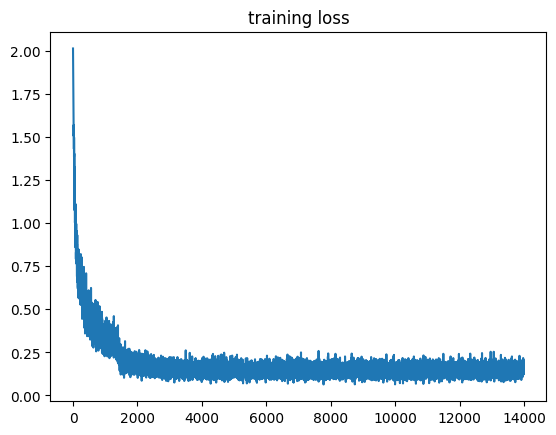

In [19]:
log_interval = 20
n_epoch = 200

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

# Save model

In [20]:
file = "../weights/M4_3500.pth"
torch.save(model, file)

In [21]:
# file = "../weights/scripted_model_8000.pt"
# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save(file) # Save

In [70]:
import numpy as np


def normalize(array):
    mn = torch.min(array)
    mx = torch.max(array)
    return (array - mn) / (mx - mn)


def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    idx = get_likely_index(tensor)
    # print(idx)
    normed = normalize(tensor.squeeze())
    prob = normed / torch.sum(normed)
    tensor = index_to_label(idx.squeeze())
    return tensor, prob[idx.squeeze()].item()


waveform, sample_rate, utterance, *_ = train_set[2]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: backward. Predicted: ('backward', 0.4110463559627533).


In [71]:
waveform, *_ = test_set[50]
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [72]:
len(test_set)

2337

In [75]:
for i in range(0, 2337, 50):
    waveform, sample_rate, utterance, *_ = test_set[i]
    print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: right. Predicted: ('left', 0.2820636034011841).
Expected: right. Predicted: ('right', 0.28661972284317017).
Expected: right. Predicted: ('off', 0.29391923546791077).
Expected: right. Predicted: ('right', 0.2873322069644928).
Expected: right. Predicted: ('stop', 0.3356190025806427).
Expected: right. Predicted: ('backward', 0.2687470018863678).
Expected: right. Predicted: ('right', 0.3901662826538086).
Expected: right. Predicted: ('stop', 0.3550357222557068).
Expected: backward. Predicted: ('backward', 0.3231675326824188).
Expected: backward. Predicted: ('backward', 0.3225235641002655).
Expected: backward. Predicted: ('backward', 0.3425339162349701).
Expected: backward. Predicted: ('backward', 0.47718116641044617).
Expected: left. Predicted: ('left', 0.24899359047412872).
Expected: left. Predicted: ('left', 0.25553610920906067).
Expected: left. Predicted: ('left', 0.2923568785190582).
Expected: left. Predicted: ('left', 0.2937542200088501).
Expected: left. Predicted: ('left', 0